# preliminaries

## load packages

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data 
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#plotting
import seaborn as sns 
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# custom code
from src import features, annotation, parameters, segmentation, spectrogramming


## define path variables

In [17]:
#paths to raw data
all_wav_development = '/peromyscus-pup-vocal-evolution/data/audio/raw/development/'
all_wav_bw_po_cf = '/peromyscus-pup-vocal-evolution/data/audio/raw/bw_po_cf/'
all_wav_bw_po_f1 = '/peromyscus-pup-vocal-evolution/data/audio/raw/bw_po_f1/'
all_wav_bw_po_f2 = '/peromyscus-pup-vocal-evolution/data/audio/raw/bw_po_f2/'

#paths to processed data
recording_lengths_dir = '/peromyscus-pup-vocal-evolution/data/recording_lengths/'

#paths to clips for developmental dataset
all_voc_clips_dirs = '/peromyscus-pup-vocal-evolution/data/audio/clips/'

segments_root = '/peromyscus-pup-vocal-evolution/data/audio/segments/'
annotations_root = '/peromyscus-pup-vocal-evolution/data/annotations/'
acoustic_features_root = '/peromyscus-pup-vocal-evolution/data/features/acoustic_features/'
clips_root = '/peromyscus-pup-vocal-evolution/data/audio/clips/'
specs_root = '/peromyscus-pup-vocal-evolution/data/features/spectrograms/'
models_root = '/peromyscus-pup-vocal-evolution/data/models/random_forest/'
noise_floors_path = '/peromyscus-pup-vocal-evolution/data/audio/noise/all_noise_floors.csv'

#amplitdue segments
amplitude_acoustic_features = '/peromyscus-pup-vocal-evolution/data/features/acoustic_features/amplitude_segmented/development/20220913_063001/'
amplitude_umap = '/peromyscus-pup-vocal-evolution/data/features/spectrograms/amplitude_segmented/final/umap_coordinates/'
amplitude_umap_HDBSCAN_labeled = '/peromyscus-pup-vocal-evolution/data/annotations/annotations_from_umap/'
amplitude_voc_clips = '/peromyscus-pup-vocal-evolution/data/audio/clips/development/'

#params and clipping
params_dict_path = '/peromyscus-pup-vocal-evolution/parameters/'
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
clipping_path = '/peromyscus-pup-vocal-evolution/data/clipping/all_development_clipping.csv'
clipping_path_bw_po_cf = '/peromyscus-pup-vocal-evolution/data/clipping/all_bw_po_cf_clipping.csv'
clipping_path_bw_po_f1 = '/peromyscus-pup-vocal-evolution/data/clipping/all_bw_po_f1_clipping.csv'
clipping_path_bw_po_f2 = '/peromyscus-pup-vocal-evolution/data/clipping/all_bw_po_f2_clipping.csv'
spl_path = '/peromyscus-pup-vocal-evolution/data/SPL/all_development_SPL.csv'



# Figure 1

## color UMAP by HDBSCAN cluster (Figure 1C top)

### collect UMAP data

In [18]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

In [47]:
#choose species decide what to save
species = 'MZ'
save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


### plot with HDBSCAN labels

In [174]:
#decide to save or not
save_labeled_umap_plot = False

#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

if species in ['MU', 'MZ']: #color dictionary for MU and MZ - make points ignored by HDBSCAN the same color as the
                            #the ones it considered "clusters"
    HDBSCAN_color_dict = {0: 'thistle', 
                          -1:'thistle'}
else: #color dictionary for Peromyscus taxa
    HDBSCAN_color_dict = {0: 'thistle', 
                          1: 'deeppink'}

colmap = df_umap['label'].map(HDBSCAN_color_dict)

ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = colmap,
    s = .5,
    alpha = .75, 
    cmap=None)

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
sns.despine()

if save_labeled_umap_plot:
    save_dir = ''
    save_name = ('_').join([species,'final_amplitude_HDBSCAN_labeled_umap.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)

plt.show()


## Average spectrograms (Figure 1C middle/bottom)

In [44]:
#set the path to the vocalization clips and make sure it exists
clips_dir = os.path.join(amplitude_voc_clips, species)
assert os.path.exists(clips_dir)

#get path to each wav clip
all_files = [os.path.join(clips_dir,i) for i in df_umap['source_file']]

In [45]:
#set the spectrogram parameters
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': 0.5, # minimum log-spectrogram value 
    'fs': 250000, # audio samplerate
    'fill_value': 0.5,
    'max_duration':0.5, #set the max duration of each spectrogram to 0.5 seconds for all vocs and species
    'num_time_bins':256,
    'num_freq_bins':256,
    'spec_max_val':10
}

In [23]:
#generate the spectrograms

if species not in ['MU', 'MZ']: #if there are two clusters, generate spectrograms separately for each one
    
    label_0_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 0]]
    label_1_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 1]]
    
    #get the label 0 specs
    label_0_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_0_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    #get the label 1 specs
    label_1_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_1_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')


else:
    #get all the specs
    all_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                        noise_floors_path=noise_floors_path, 
                                                        species = None, 
                                                        filtered_clips = all_files,
                                                        noise_floor = None,
                                                        spec_params=spec_params, 
                                                        num_to_process = 'all')


In [24]:
save = False

############################################################################################################

if species not in ['MU', 'MZ']: 
    
    #average the spectrograms you just generated
    label0_spec_avg = spectrogramming.spec_avg_from_list(label_0_specs_list)
    label1_spec_avg = spectrogramming.spec_avg_from_list(label_1_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=2, 
                             ncols=1, 
                             figsize=(5,10))
    
    
    #plot label 0 average
    axes[0].set_axis_off()
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[0].matshow(label0_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #plot label 1 average
    axes[1].set_axis_off()
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].matshow(label1_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #save 
    if save:
        save_dir = ''
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
else: 
    
    #average the spectrograms you just generated
    all_spec_avg = spectrogramming.spec_avg_from_list(all_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=1, 
                             ncols=1, 
                             figsize=(5,5))
    
    
    #plot label 0 average
    axes.set_axis_off()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    axes.matshow(all_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

    #save 
    if save:
        save_dir = ''
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
    

## PCA of acoustic features (Figure 1 panel D)

### set color palettes

In [ ]:
species_color_dict = params_dict['figure_1_panel_d']['species_color_dict']
genus_color_dict = params_dict['figure_1_panel_d']['genus_color_dict']
voc_name_color_dict = params_dict['figure_1_panel_d']['voc_name_color_dict']
HDBSCAN_color_dict = params_dict['figure_1_panel_d']['HDBSCAN_color_dict']

### get/clean the features and UMAP cluster labels for all species

In [7]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#remove vocalizations that have nan for at least one acoustic feature (all of these are from MU)
nans = features_df['source_file'].iloc[pd.isnull(features_df).any(1).to_numpy().nonzero()]
features_df = features_df.loc[~features_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)
umap_df = umap_df.loc[~umap_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)

#make sure the source files are identical and merge
print('merging...')
merged_df = features_df.merge(umap_df, how='left', on='source_file')
assert merged_df['source_file'].equals(features_df['source_file'])

print('done.')

getting umap HDBSCAN labels...
getting features...
merging...
done.


In [8]:
species_list = ['BW', 'SW', 'BK', 'NB', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ']
ages = ['p1', 'p3', 'p5', 'p7', 'p9', 'p11', 'p13']

umap_df['pup'] = [i.split('_clip')[0] for i in umap_df['source_file']]
umap_df['species'] = [i.split('_')[0] for i in umap_df['source_file']]
umap_df['age'] = [i.split('_')[-5] if not i.split('_')[0] in ['MZ'] else i.split('_')[10] if 'R' not in i else i.split('_')[10] for i in umap_df['source_file']]
umap_df['litter'] = [('_').join(i.split('_')[:3]+i.split('_')[-4:-2]) if not i.split('_')[0] in ['MZ'] else ('_').join([i.split('_')[0], i.split('_')[-4],i.split('_')[10],  i.split('_')[9]]) for i in umap_df['source_file']]

print('Total vocalizations detected:', len(umap_df))
print('Total pups recorded:', len(umap_df['pup'].unique()))
print('Total litters recorded:', len(umap_df['litter'].unique()))
print('Total Peromyscus pups recorded:', len(umap_df['pup'].loc[~umap_df['species'].isin(['MU', 'MZ'])].unique()))

print('Pups per species:')
for species in species_list:
    print('\t',species,':', len(umap_df['pup'].loc[umap_df['species'] == species].unique()))
print('Vocalizations per species:')
for species in species_list:
    print('\t',species,':', len(umap_df.loc[umap_df['species'] == species]))
print('Litters per age per species:')
for species in species_list:
    print(species)
    for age in ages:
        print('\t',age,':', len(umap_df['litter'].loc[umap_df['species'] == species].loc[umap_df['age'] == age].unique()))

Total vocalizations detected: 287461
Total pups recorded: 794
Total litters recorded: 216
Total Peromyscus pups recorded: 578
Pups per species:
	 BW : 76
	 SW : 73
	 BK : 97
	 NB : 70
	 PO : 71
	 LO : 66
	 GO : 66
	 LL : 59
	 MU : 107
	 MZ : 109
Vocalizations per species:
	 BW : 30130
	 SW : 27289
	 BK : 42244
	 NB : 34079
	 PO : 10468
	 LO : 19429
	 GO : 66868
	 LL : 18371
	 MU : 26538
	 MZ : 12045
Litters per age per species:
BW
	 p1 : 3
	 p3 : 4
	 p5 : 3
	 p7 : 3
	 p9 : 3
	 p11 : 3
	 p13 : 3
SW
	 p1 : 2
	 p3 : 3
	 p5 : 2
	 p7 : 2
	 p9 : 3
	 p11 : 3
	 p13 : 3
BK
	 p1 : 3
	 p3 : 3
	 p5 : 3
	 p7 : 3
	 p9 : 3
	 p11 : 3
	 p13 : 3
NB
	 p1 : 3
	 p3 : 3
	 p5 : 3
	 p7 : 3
	 p9 : 3
	 p11 : 3
	 p13 : 3
PO
	 p1 : 3
	 p3 : 3
	 p5 : 3
	 p7 : 3
	 p9 : 3
	 p11 : 3
	 p13 : 3
LO
	 p1 : 3
	 p3 : 3
	 p5 : 3
	 p7 : 3
	 p9 : 3
	 p11 : 3
	 p13 : 3
GO
	 p1 : 3
	 p3 : 3
	 p5 : 3
	 p7 : 3
	 p9 : 5
	 p11 : 3
	 p13 : 3
LL
	 p1 : 2
	 p3 : 3
	 p5 : 3
	 p7 : 3
	 p9 : 6
	 p11 : 4
	 p13 : 2
MU
	 p1 : 2
	 p3 : 3
	 p

### do PCA

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#get the features
features_set = params_dict['figure_1_panel_d']['features']
pca_df = features_df[features_set]

# Standardizing the features
standardized_features = StandardScaler().fit_transform(pca_df)

#2 component PCA
print('doing PCA...')
pca = PCA(n_components = 2)
pca_embedding = pca.fit_transform(standardized_features)
print('\texplained variance by PC:', pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(pca.explained_variance_ratio_))

#add to features_df
features_df['pc_1'] = pca_embedding[:,0]
features_df['pc_2'] = pca_embedding[:,1]

print('done.')

### get PCA loadings

In [179]:
loadings = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'], index=pca_df.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])
loadings = loadings.sort_values(by = ['pc1'], ascending=False)

### plot

In [20]:


save = False


fig = plt.figure(figsize = [4,4], dpi= 200)
ax1 = fig.add_subplot(1,1,1)

colors = features_df['species'].map(genus_color_dict)

#plot Peromyscus
ax1.scatter(features_df['pc_1'].loc[~features_df['species'].isin(['MU', 'MZ'])], 
            features_df['pc_2'].loc[~features_df['species'].isin(['MU', 'MZ'])],
            c= features_df['species'].loc[~features_df['species'].isin(['MU', 'MZ'])].map(genus_color_dict),
            alpha = .0075, 
            s=.5)

#plot Mus
ax1.scatter(features_df['pc_1'].loc[features_df['species'].isin(['MU', 'MZ'])], 
            features_df['pc_2'].loc[features_df['species'].isin(['MU', 'MZ'])],
            c= features_df['species'].loc[features_df['species'].isin(['MU', 'MZ'])].map(genus_color_dict),
            alpha = .015, 
            s=.5)

ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

sns.despine()


if save:
    save_dir = ''
    save_name = 'figure1_PCA.jpeg'
    plt.savefig(os.path.join(save_dir,save_name), dpi=600)
    
    

## Violin Plots of Acoustic Features by Species (Figure 1E)

In [21]:

#set up the figures
fig = plt.figure(figsize = [5,5], constrained_layout=True, dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
order = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ']

#plot the dots
sns.stripplot(data = features_df, ax = ax1, y='duration', x='species', hue = 'species', alpha=.01, s=.75, jitter=.075, order=order, palette = species_color_dict)
sns.stripplot(data = features_df, ax = ax2, y='meanfreq',x='species', hue = 'species', alpha=.01, s=.75, jitter=.075, order=order, palette = species_color_dict)

#plot the violins
sns.violinplot(data = features_df, ax = ax1, y='duration', x='species', scale = 'width', width = .75, alpha=1, order=order, inner=None, color = 'lightgray', linewidth=0)
sns.violinplot(data = features_df, ax = ax2, y='meanfreq', x='species', scale = 'width', width = .75, alpha=1, order=order, inner=None, color = 'lightgray', linewidth=0)

#remove the unecessary boundaries and legends
sns.despine()
ax1.legend([],[], frameon = False)
ax2.legend([],[], frameon = False)

## Hierarchical Clustering of Acoustic Features (Figure 1 panel F)

### sample the data

In [22]:
from sklearn.preprocessing import MinMaxScaler

#set seed for reproducible sampling
seed = params_dict['figure_1_panel_f']['sampling_seed']

#get the features
features_set = params_dict['figure_1_panel_f']['features']

#get how many vocs to sample
num_to_sample = params_dict['figure_1_panel_f']['num_to_sample']

#sample 
cluster_df = merged_df.sample(n=num_to_sample, random_state=seed)
print('sampled',len(cluster_df),'vocalizations...')

#scale the columns 
print('scaling...')
standardized_features = pd.DataFrame(MinMaxScaler().fit_transform(cluster_df[features_set]), columns = features_set, index=cluster_df.index)
standardized_features = standardized_features[features_set]

print('done.')

### cluster

In [25]:
from sklearn.cluster import AgglomerativeClustering, KMeans

#define the distance below which leaves will not be merged
distance_threshold = params_dict['figure_1_panel_f']['distance_threshold']

#define the clustering model to use
clusterer = AgglomerativeClustering(n_clusters=None, 
                                    affinity='euclidean', 
                                    linkage='ward', 
                                    compute_full_tree=True, 
                                    distance_threshold = distance_threshold)
#use it
print('clustering...')
clusterer.fit_predict(standardized_features)

#get clustering results
cluster_labels = clusterer.labels_
num_clusters = clusterer.n_clusters_

print('done.')

### plot

In [26]:
#may take a few minutes

#set the colors
voc_colmap = cluster_df['label'].astype(str).map(HDBSCAN_color_dict)
species_colmap = cluster_df['species_x'].map(species_color_dict)
genus_colmap = cluster_df['species_x'].map(genus_color_dict)
row_colors = [voc_colmap, species_colmap, genus_colmap]

#plot
sns.clustermap(standardized_features,
               method = 'ward', 
               cmap = 'viridis', 
               col_cluster=False,
               figsize = (15, 12),
               cbar_pos=(0, .2, .03, .1),
               row_colors = row_colors, 
               mask = None, 
               colors_ratio=.03, 
               tree_kws={'linewidth':2})


# Figure 2

## get model to predict vocalization types (cry, USV, non-vocal)

In [27]:
#model ID
model_ID = '20230203_044016'

#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], 
                               save_name=os.path.split(voc_type_params_path)[1])


## get/clean features

In [28]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#add clipping information
clipping_df = pd.read_csv(clipping_path)
features_df = features_df.merge(clipping_df, how='left', on='source_file')

#remove vocalizations that have nan for at least one acoustic feature (all of these are from MU)
nans = features_df['source_file'].iloc[pd.isnull(features_df).any(1).to_numpy().nonzero()]
features_df = features_df.loc[~features_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)
umap_df = umap_df.loc[~umap_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)

#make sure the source files are identical and merge
print('merging...')
assert umap_df['source_file'].equals(features_df['source_file'])
merged_df = features_df.merge(umap_df, on='source_file')
assert(merged_df['species_x'].equals(merged_df['species_y']))
merged_df = merged_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
merged_df['pup'] = [i.split('_clip')[0]+'.wav' for i in merged_df['source_file']]

#drop pups whose recordings were found to contain artefacts (vertical lines caused by data transfer issue) during annotation
pups_to_drop = params_dict['excluded_pups']['development']
print('dropping', len(merged_df.loc[merged_df['pup'].isin(pups_to_drop)]), 'vocs because they come from bad recordings...')
merged_df = merged_df.loc[~merged_df['pup'].isin(pups_to_drop)]
assert len(merged_df.loc[merged_df['pup'].isin(pups_to_drop)]) == 0

print('done.')

## predict vocalization labels from features 

In [7]:
#this takes a few minutes 

#get the features you trained on
for_prediction = merged_df[model_params['feature_set']]

#predict vocalization type from those features
predicted_labels = voc_type_model.predict(for_prediction)

#add them to the dataset
merged_df['predicted_label'] = predicted_labels
assert set(merged_df['predicted_label'].unique()) == set(['cry', 'USV', 'scratch'])

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [8]:
save = False

save_dir = ''
all_predicted_save_name = 'figure2_all_development_vocs_with_predictions.csv'

if save:
    merged_df.to_csv(os.path.join(save_dir, all_predicted_save_name), index=False)


## general average spectrograms by label (Supplemental Figure 3)

In [ ]:
#load
save_dir = ''
all_predicted_save_name = 'figure2_all_development_vocs_with_predictions.csv'
merged_df = pd.read_csv(os.path.join(os.path.join(save_dir, all_predicted_save_name)))

#make the spectrograms using a common max duration for all vocalizations and species (.5 seconds)
species_list = ['GO'] 

for species in species_list:
    print(species)
    max_dur = 0.5
    clips_dir = os.path.join(amplitude_voc_clips, species)
    cry_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'cry'].loc[merged_df['species'] == species]]
    USV_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'USV'].loc[merged_df['species'] == species]]
    scratch_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'scratch'].loc[merged_df['species'] == species]]

    spec_params = {
        'min_freq': 5000, # minimum frequency
        'max_freq': 125000, # maximum frequency
        'nperseg': 512, # FFT
        'noverlap': 512 // 4, # FFT
        'spec_min_val': 0.5, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
        'fs': 250000, # audio samplerate
        'downsample_by':2, #2 means take every other pixel from the original spectrogram - only usedin interpolate = False
        'log_resize_scaling_factor':None, 
        'fill_value': .5,
        'max_duration':max_dur,
        'num_time_bins':256,
        'num_freq_bins':256,
        'spec_max_val':10
    }

    print('getting cry specs...')
    cry_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = cry_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    print('getting USV specs...')
    USV_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = USV_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    print('getting scratch specs...')
    scratch_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = scratch_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    


In [29]:
#show the specs
save = False

cry_spec_avg = spectrogramming.spec_avg_from_list(cry_specs_list)
USV_spec_avg = spectrogramming.spec_avg_from_list(USV_specs_list)
scratch_spec_avg = spectrogramming.spec_avg_from_list(scratch_specs_list)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

print('making cry spec...')
ax1.set_axis_off()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title(species+' predicted cry n='+str(len(cry_specs_list)))
ax1.matshow(cry_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

print('making USV spec...')
ax2.set_axis_off()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title(species+' predicted USV n='+str(len(USV_specs_list)))
ax2.matshow(USV_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

print('making scratch spec...')
ax3.set_axis_off()
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title(species+' predicted nonvocal n='+str(len(scratch_specs_list)))
ax3.matshow(scratch_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

#save it
if save:
    save_dir = ''
    save_name = ('_').join([species,'RF_predicted_labels_20230205.svg'])
    plt.savefig(fname=os.path.join(save_dir,save_name))

# del cry_spec_avg
# del USV_spec_avg
# del scratch_spec_avg
# del cry_specs_list
# del USV_specs_list
# del scratch_specs_list

## aggregate labeled vocalizations by pup

In [119]:
#get the features to aggregate

#path to params (and features) for labeling amplitude segmented vocalizations as cry, scratch or whistle 
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], 
                               save_name=os.path.split(voc_type_params_path)[1])


In [175]:
save_dir = ''
all_predicted_save_name = 'figure2_all_development_vocs_with_predictions.csv'
merged_df = pd.read_csv(os.path.join(os.path.join(save_dir, all_predicted_save_name)))

#choose the dataset

dataset='development'
raw_wavs_root = all_wav_development    

#get the pups that you want to aggregate features from
print('getting pups...')

#exclude pups that have recording artefacts
pups_to_drop = params_dict['excluded_pups']['development']

#get the pups to aggregate 
merged_df['pup'] = [i.split('.')[0] for i in merged_df['pup']]
source_list = [i for i in merged_df['pup'].unique() if i not in pups_to_drop and i.split('_')[0] not in ['MZ', 'MU', 'IS']]

#get the features 
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = dataset, 
                                                                 features = features_to_aggregate, 
                                                                 features_df = merged_df, 
                                                                 drop_clipped=True) 
print('done.')

In [11]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

In [120]:
#add the pups that made no detected sounds 

print('adding nonvocal pups...')
#find them
non_vocal_pups = [i.split('.')[0] for i in sorted(os.listdir(all_wav_development)) if i.split('.')[0] not in sorted(vocal_pups['pup']) and i.split('_')[0] not in ['MU', 'MZ', 'IS']]

#get their metadata
non_vocal_meta_data_list = []
for pup in non_vocal_pups:
    pup_metadata = features.get_pup_metadata(source_path = pup, dataset = 'development')
    non_vocal_meta_data_list.append(pup_metadata)
non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

#make columns for their features (which will be all nan)
non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

#add to the vocalizing pups
assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
all_pups = pd.concat([vocal_pups, non_vocal_data_df])
all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

#make sure you have all the pups now
assert len(all_pups) == len([i for i in os.listdir(all_wav_development) if i.split('_')[0] not in ['MU', 'MZ', 'IS']])

#get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
print('getting recording lengths...')
rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'development_recording_lengths')
all_pups['pup'] = [('.').join([i, 'wav']) for i in all_pups['pup']]
rec_length_df = pd.DataFrame()
rec_length_df['pup'] = rec_length_dict.keys()
rec_length_df['recording_length'] = rec_length_dict.values()
rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
all_pups = all_pups.merge(rec_length_df, on='pup')
    
#replace count nan with 0 and add some useful columns
print('finalizing dataset...')
all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
all_pups['start_temp'] = [float(i.split('_')[7])/10 for i in all_pups['pup']]
all_pups['end_temp'] = [float(i.split('_')[8])/10 for i in all_pups['pup']]
all_pups['temp_loss'] = all_pups['end_temp'] - all_pups['start_temp']
all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']

print('done.')

## get annotated vocalizations for species comparisons

In [30]:
#collect the annotations
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

#get the annotations
print('getting annotations...')
all_combined = annotation.get(annotations_root, species_list)

#TO DO remove this once you change labels
all_combined['human_label'] = ['USV' if i=='whistle' else i for i in all_combined['human_label']]
    
#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#merge keeping only source files that have been annotated
print('merging...')
annotated_df = features_df.merge(all_combined, how='right',on='source_file').reset_index(drop=True)
assert(annotated_df['species_x'].equals(annotated_df['species_y']))
annotated_df = annotated_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
annotated_df['pup'] = [i.split('_clip')[0] for i in annotated_df['source_file']]

#add columns for useful info from file names
annotated_df['litter'] = [i.split('_')[1]+'_'+i.split('_')[-2] for i in annotated_df['pup']]
annotated_df['voc_number'] = [int(i.split('_')[-1].split('.')[0]) for i in annotated_df['source_file']]
annotated_df['sex'] = [i.split('_')[6] for i in annotated_df['pup']]
annotated_df['start_temp'] = [float(i.split('_')[7])/10 for i in annotated_df['source_file']]
annotated_df['end_temp'] = [float(i.split('_')[8])/10 for i in annotated_df['source_file']]
annotated_df['temp_loss'] = all_pups['end_temp'] - annotated_df['start_temp']
annotated_df['weight_mg'] = [float(i.split('_')[5]) for i in annotated_df['source_file']]
annotated_df['age'] = [float(i.split('_')[-5][1:]) if not i.split('_')[-5] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['removal_flag'] = [float(i.split('_')[-6][-1]) if not i.split('_')[-6] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['duration'] = [i*1000 for i in annotated_df['duration']]
print('done.')

In [176]:
#these are pups are those with a lot fo artefacts (big vertical lines) identified during annotations for das
pups_to_drop = params_dict['excluded_pups']['development']

#make sure they are dropped (should have happened above)
assert len(annotated_df.loc[annotated_df['pup'].isin(pups_to_drop)]) == 0
print(len(annotated_df))

#drop clipped vocalizations
print('dropping clipped vocalizations...')
clipping_df = pd.read_csv(clipping_path)
annotated_df_not_clipped = annotated_df.merge(clipping_df, how='left', on='source_file')
annotated_df_not_clipped = annotated_df_not_clipped.loc[annotated_df_not_clipped['percent_clipped']==0]
print(len(annotated_df_not_clipped))

# drop forcibly removed pups
print('dropping forcibly removed pups...')
ds_df = annotated_df_not_clipped.loc[annotated_df_not_clipped['removal_flag']==0]
ds_df['temp_loss'] = ds_df['end_temp'] - ds_df['start_temp']
print(len(ds_df))
all_pups_for_plotting = all_pups.loc[all_pups['removal_flag']==0]

assert sum(all_pups_for_plotting['removal_flag']) == 0
assert sum(ds_df['removal_flag']) == 0

print('done.')

In [43]:
# save

save = False

save_dir = ''
vocs_save_name = 'figure2CD_vocs_data_20230206.csv'
pups_save_name = 'figure2CD_pups_data_20230206.csv'

if save:
    ds_df.to_csv(os.path.join(save_dir, vocs_save_name), index=False)
    all_pups_for_plotting.to_csv(os.path.join(save_dir, pups_save_name), index=False)
    all_pups.to_csv(os.path.join(save_dir, 'all_pups_unfiltered.csv'), index=False)


## plot counts and features (Figure 2 C/D )

In [5]:
fig2CD_vocs_data_path = ""
fig2CD_pups_data_path = ""

#get the data
fig2CD_vocs_data = pd.read_csv(fig2CD_vocs_data_path)
fig2CD_pups_data = pd.read_csv(fig2CD_pups_data_path)


In [31]:
save = False

###################################################################################################################

order = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL']

fontsize = 9
ytick_length = 2
ytick_pad = 0.5

rate_dots_jitter = 0.1
rate_dots_size = 2
rate_dots_alpha = 0.5

feature_dots_jitter = 0.05
feature_dots_size = 1
feature_dots_alpha = .25

###################################################################################################################

#get ages
cry_df = fig2CD_vocs_data.loc[fig2CD_vocs_data['human_label'] == 'cry']
USV_df = fig2CD_vocs_data.loc[fig2CD_vocs_data['human_label'] == 'USV']
all_pups_for_plotting = fig2CD_pups_data

sns.set(style="ticks", color_codes=True)
fig, axes = plt.subplot_mosaic(mosaic="ACBBDD;EGFFHH;IKJJLL", 
                               figsize=[8,4], 
                               constrained_layout=True, 
                               dpi=600)

# # get the colors
# colors = pd.Series(data['species'].unique()).map(species_color_dict)

#define the colors
species_color_dict = {'BW':'steelblue',
                      'NB': 'dodgerblue',
                      'BK': 'darkblue',
                      'SW': 'blue',
                      'PO': 'orange',
                      'LO': 'gold',
                      'GO': 'green',
                      'LL': 'forestgreen',
                      'MU': 'mediumspringgreen', 
                      'MZ': 'turquoise'}


# to iterate through
features_to_plot = ['duration', 'meanfreq']
cry_axes = ['A', 'E']
whis_axes = ['C', 'G']

#plot the cry acoustic features_to_plot at p9
for cry_axis, feature in zip(cry_axes, features_to_plot):
    
    #remove outliers
    data = cry_df.loc[cry_df['age'] == 9]
    
    #cry dots
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          x='species',
          jitter=feature_dots_jitter,
          y= feature, 
          color='black', 
          order=order, 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #cry boxes
    box = sns.violinplot(ax=axes[cry_axis], 
                data=data,
                x='species', 
                y=feature, 
                order=order, 
                linewidth=0.5, 
                palette=species_color_dict, 
                saturation=.5, 
                inner='quartile')

    #prettify
    box.legend([],[], frameon=False)
    if feature == 'duration':
        axes[cry_axis].set_ylabel(ylabel = 'duration (ms)', fontsize = fontsize)
    elif feature == 'meanfreq':
        axes[cry_axis].set_ylabel(ylabel = 'mean freq. (kHz)', fontsize = fontsize)
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
        
    for label in (axes[cry_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[cry_axis].set_xticks([], [])
    
    axes[cry_axis].get_xaxis().set_visible(False)
    axes[cry_axis].yaxis.set_tick_params(width=.5, rotation = 0, length=ytick_length, pad = ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(width=.5, rotation = 0, length=ytick_length, pad = ytick_pad)
    if feature == 'meanfreq':
        axes[cry_axis].set_ylim([0,100])
        axes[cry_axis].set_yticks([0,25,50,75,100])
    if feature == 'duration':
        axes[cry_axis].set_ylim([0,400])
        axes[cry_axis].set_yticks([0,100,200,300,400])
    sns.despine()
        
# plot the USV acoustic features_to_plot at p9
for USV_axis, feature in zip(whis_axes, features_to_plot):
        
    #remove outliers
    data = USV_df.loc[USV_df['age'] == 9]

    #USV boxes
    box = sns.violinplot(ax=axes[USV_axis], 
                data=data,
                x='species', 
                y=feature, 
                order=order, 
                linewidth=0.5, 
                palette=species_color_dict, 
                saturation=.5, 
                inner='quartile')

    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          x='species', 
          jitter=feature_dots_jitter,
          y=feature, 
          color='black', 
          order=order, 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
        
    for label in (axes[USV_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[USV_axis].set_xticks([], [])
    axes[USV_axis].get_xaxis().set_visible(False)
    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].set_yticks([0,25,50,75,100])
    if feature == 'meanfreq':
        axes[USV_axis].set_ylim([0,100])
    if feature == 'duration':
        axes[USV_axis].set_ylim([0,100])
    sns.despine()
        
#plot the cry rates at p9
cry_axes = ['I']
whis_axes = ['K']
feeatures = ['_per_sec']

for cry_axis in cry_axes:
    
    data = all_pups_for_plotting.loc[all_pups_for_plotting['age'] == 9]

    #cry dots
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='species', 
          y= 'cry_per_sec', 
          color='black', 
          order=order, 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #cry boxes
    box = sns.boxplot(ax=axes[cry_axis], 
                data=data,
                x='species', 
                y='cry_per_sec', 
                order=order, 
                linewidth=.5, 
                palette=species_color_dict, 
                saturation=.5, 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)

    #prettify
    box.legend([],[], frameon=False)
    axes[cry_axis].set_ylabel(ylabel = 'rate (vocs/s)', fontsize=fontsize)
    axes[cry_axis].set_xlabel(xlabel = 'species (age 9 days)', fontsize=fontsize)
    axes[cry_axis].set_yticks([0,.5,1,1.5,2])
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
    for label in (axes[cry_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
    for label in (axes[cry_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[cry_axis].set_yticks([0,0.5,1,1.5, 2])
    axes[cry_axis].yaxis.set_tick_params(length = ytick_length, width=.5, rotation = 0, pad=ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(length = ytick_length, width=.5, rotation = 0, pad=ytick_pad)
    axes[cry_axis].set_ylim([0,2])
    sns.despine()
       
        
#plot the USV rates at p9        
for USV_axis in whis_axes:
        
    data = all_pups_for_plotting.loc[all_pups_for_plotting['age'] == 9]

    #USV boxes
    box = sns.boxplot(ax=axes[USV_axis], 
                data=data,
                x='species', 
                y='USV_per_sec', 
                order=order, 
                linewidth=.5, 
                palette=species_color_dict, 
                saturation=.5, 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)

    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='species', 
          y='USV_per_sec',
          color='black', 
          order=order, 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    axes[USV_axis].set_xlabel(xlabel = 'species (age 9 days)', fontsize=fontsize)
    axes[USV_axis].set_yticks([0,.5,1,1.5,2])
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
    for label in (axes[USV_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
    for label in (axes[USV_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    #axes[USV_axis].set_xticks([], [])
    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].set_ylim([0,2])
    sns.despine()


#add time courses    
bwpo_cry_axes = ['B', 'F', 'J']
bwpo_USV_axes = ['D', 'H', 'L']

#get data for BW and PO
cry_bwpo_df = cry_df.loc[(cry_df['species'] == 'BW' ) | (cry_df['species'] == 'PO' )]
USV_bwpo_df = USV_df.loc[(USV_df['species'] == 'BW' ) | (USV_df['species'] == 'PO' )]

#plot the BW_PO time course for the cry acoustic features_to_plot
for cry_axis, feature in zip(bwpo_cry_axes, features_to_plot):
    
    #cry dots
    data = cry_bwpo_df

    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          jitter=feature_dots_jitter,
          x='age', 
          y=feature, 
          hue='species', 
          color='black', 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #cry boxes
    box = sns.violinplot(ax=axes[cry_axis], 
                data=data,
                x='age', 
                y=feature, 
                dodge=True, 
                hue='species',
                linewidth=0.5, 
                palette=species_color_dict, 
                saturation=.5, 
                inner='quartile')

    #prettify
    box.legend([],[], frameon=False)
    axes[cry_axis].set_ylabel('')
    axes[cry_axis].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
    for label in (axes[cry_axis].get_yticklabels()+axes[cry_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    #axes[cry_axis].set_xticks([], [])
    axes[cry_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    if feature == 'meanfreq':
        axes[cry_axis].set_ylim([0,100])
        axes[cry_axis].set_yticks([0,25,50,75,100])
    if feature == 'duration':
        axes[cry_axis].set_ylim([0,400])
        axes[cry_axis].set_yticks([0,100,200,300,400])
    sns.despine()

#plot the BW_PO time course for the USV acoustic features_to_plot       
for USV_axis, feature in zip(bwpo_USV_axes, features_to_plot):
    
    data = USV_bwpo_df.loc[~USV_bwpo_df['age'].isin([1, 3])] #drop ages where PO makes no wbistls
    
    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          jitter=feature_dots_jitter,
          x='age', 
          y=feature, 
          hue='species', 
          color='black', 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #USV boxes
    box = sns.violinplot(ax=axes[USV_axis], 
                      data=data,
                      x='age', 
                      y=feature,  
                      dodge=True, 
                      hue='species',
                      linewidth=0.5, 
                      palette=species_color_dict, 
                      saturation=.5, 
                      inner='quartile')

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    axes[USV_axis].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
    for label in (axes[USV_axis].get_yticklabels() + axes[USV_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    #axes[USV_axis].set_xticks([], [])
    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].set_yticks([0,25,50,75,100])
    if feature == 'meanfreq':
        axes[USV_axis].set_ylim([0,100])
    if feature == 'duration':
        axes[USV_axis].set_ylim([0,100])
    sns.despine()
    
#plot the rates for the BW PO time course 
bwpo_cry_axes = ['J']
bwpo_USV_axes = ['L']

#get data for BW and PO
bwpo_df = all_pups_for_plotting.loc[(all_pups_for_plotting['species'] == 'BW' ) | (all_pups_for_plotting['species'] == 'PO' )]
colors = bwpo_df['species'].map(species_color_dict)

#plot the rates for the BW PO time course cries
for cry_axis in bwpo_cry_axes:
    #cry dots
    
    data = bwpo_df
    
    #cry dots
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='age', 
          y='cry_per_sec', 
          hue='species', 
          color='grey', 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #cry boxes
    box = sns.boxplot(ax=axes[cry_axis], 
                data=data,
                x='age', 
                y='cry_per_sec', 
                dodge=True, 
                hue='species',
                linewidth=.5, 
                palette=species_color_dict, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)

    #prettify
    box.legend([],[], frameon=False)
    axes[cry_axis].set_ylabel('')
    axes[cry_axis].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
    for label in (axes[cry_axis].get_yticklabels() + axes[cry_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
    
    axes[cry_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[cry_axis].set_yticks([0,.5,1,1.5,2])
    axes[cry_axis].spines.bottom.set_visible(False)
    axes[cry_axis].set_ylim([0,2])
    sns.despine()
        
        
#plot the rates for the BW PO time course USVs
for USV_axis, feature in zip(bwpo_USV_axes, features_to_plot):
    
    data = bwpo_df
    
    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='age', 
          y='USV_per_sec', 
          hue='species', 
          color='grey', 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #USV boxes
    box = sns.boxplot(ax=axes[USV_axis], 
                      data=data,
                      x='age', 
                      y='USV_per_sec',  
                      dodge=True, 
                      hue='species',
                      linewidth=.5, 
                      palette=species_color_dict, 
                      saturation=.5, 
                      whis=1.5, 
                      showfliers = False, 
                      flierprops={"marker": ""},
                      medianprops={"color": "black"},
                      boxprops={"linewidth": .00001}, 
                      width = .75, 
                      showcaps=False)
    

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    axes[USV_axis].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
    for label in (axes[USV_axis].get_yticklabels() + axes[USV_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    axes[USV_axis].spines.bottom.set_visible(False)
    #axes[USV_axis].set_xticks([], [])
    axes[USV_axis].set_yticks([0,.5,1,1.5,2])
    axes[USV_axis].set_ylim([0,2])
    sns.despine()
    
if save == True:
    save_dir = ''
    save_name = 'figure2CD_no_clipping_no_forcibly-removed'

    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)



### statistics (use R kernel)

In [32]:
#load packages
library(lme4)
library(emmeans)
library(lmerTest)
library(pbkrtest)
library(tidyr)

#paths to data
fig2CD_vocs_data_path <- ""
fig2CD_pups_data_path <- ""

#get the data
fig2CD_vocs_data <- read.csv(fig2CD_vocs_data_path)
fig2CD_pups_data <- read.csv(fig2CD_pups_data_path)


#### all species p9 cry duration

In [33]:
#set the data
data <- subset(fig2CD_vocs_data, human_label == "cry" & age == 9)

#scale the data
data[["duration"]] <- scale(data[["duration"]], center = TRUE, scale = TRUE)

#fit model
p9cry.duration.lme <- lmer(duration ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(p9cry.duration.lme)


#### all species p9 cry mean frequency

In [34]:
#set the data
data <- subset(fig2CD_vocs_data, human_label == "cry" & age == 9)

#scale the data
data[["meanfreq"]] <- scale(data[["meanfreq"]], center = TRUE, scale = TRUE)

#fit model
p9cry.meanfreq.lme <- lmer(meanfreq ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(p9cry.meanfreq.lme)


#### all species p9 cry rate

In [35]:
#set the data
data <- subset(fig2CD_pups_data, age == 9)

#scale the data
data[["cry_per_sec"]] <- scale(data[["cry_per_sec"]], center = TRUE, scale = TRUE)

#fit model
p9cry.cryrate.lme <- lmer(cry_per_sec ~ species + sex + (1|temp_loss), data = data)
summary(p9cry.cryrate.lme)

#### all species p9 USV duration

In [38]:
#set the data
data <- subset(fig2CD_vocs_data, human_label == "USV" & age == 9)

#scale the data
data[["duration"]] <- scale(data[["duration"]], center = TRUE, scale = TRUE)

#fit model
p9USV.duration.lme <- lmer(duration ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(p9USV.duration.lme)


#### all species p9 USV mean frequency

In [41]:
#set the data
data <- subset(fig2CD_vocs_data, human_label == "USV" & age == 9)


#scale the data
data[["meanfreq"]] <- scale(data[["meanfreq"]], center = TRUE, scale = TRUE)

#fit model
p9USV.meanfreq.lme <- lmer(meanfreq ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(p9USV.meanfreq.lme)


#### all species p9 USV rate

In [42]:
#set the data
data <- subset(fig2CD_pups_data, age == 9)

#fit model
p9USV.USVrate.lme <- lmer(USV_per_sec ~ species + sex + (1|temp_loss), data = data)
summary(p9USV.USVrate.lme)

#### BW and PO all ages cry duration

In [43]:
data = subset(fig2CD_vocs_data, human_label == "cry" & (species == "BW" | species == "PO"))

#scale the data
data[["duration"]] <- scale(data[["duration"]], center = TRUE, scale = TRUE)

bwpo.cry.duration.lm <- lmer(duration ~ species + age + sex + (1|pup) + (1|temp_loss), data = data)
summary(bwpo.cry.duration.lm)

#### BW and PO all ages cry mean frequency

In [44]:
data = subset(fig2CD_vocs_data, human_label == "cry" & (species == "BW" | species == "PO"))

#scale the data
data[["meanfreq"]] <- scale(data[["meanfreq"]], center = TRUE, scale = TRUE)

bwpo.cry.meanfreq.lm <- lmer(meanfreq ~ species + sex + age +  (1|pup) + (1|temp_loss) , data = data)
summary(bwpo.cry.meanfreq.lm)

#### BW and PO all ages cry rate

In [45]:
data = subset(fig2CD_pups_data, (species == "BW" | species == "PO"))

bwpo.cry.rate.lm <- lmer(cry_per_sec ~ species + age + sex + (1|temp_loss), data = data)
summary(bwpo.cry.rate.lm)

#### BW and PO all ages USV duration

In [46]:
data = subset(fig2CD_vocs_data, human_label == "USV" & (species == "BW" | species == "PO"))

#scale the data
data[["duration"]] <- scale(data[["duration"]], center = TRUE, scale = TRUE)

bwpo.USV.duration.lm <- lmer(duration ~ species + age + sex   + (1|pup) + (1|temp_loss), data = data)
summary(bwpo.USV.duration.lm)

#### BW and PO all ages USV mean frequency

In [47]:
data = subset(fig2CD_vocs_data, human_label == "USV" & (species == "BW" | species == "PO"))

#scale the data
#data[["meanfreq"]] <- scale(data[["meanfreq"]], center = TRUE, scale = TRUE)

bwpo.USV.meanfreq.lm <- lmer(meanfreq ~ species + age + sex +  (1|pup) + (1|temp_loss), data = data)
summary(bwpo.USV.meanfreq.lm)

#### BW and PO all ages USV rate

In [48]:
data = subset(fig2CD_pups_data, (species == "BW" | species == "PO"))
bwpo.USV.rate.lm <- lmer(USV_per_sec ~ species + age + sex + (1|temp_loss), data = data)
summary(bwpo.USV.rate.lm)


## PCA on features of annotated vocalizations (Supplemental Figure 2)

### collect annotated vocalizations

In [49]:
#collect the annotations
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

#get the annotations
print('getting annotations...')
all_combined = annotation.get(annotations_root, species_list)

#TO DO remove this once you change labels
all_combined['human_label'] = ['USV' if i=='whistle' else i for i in all_combined['human_label']]
    
#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#merge keeping only source files that have been annotated
print('merging...')
annotated_df = features_df.merge(all_combined, how='right',on='source_file').reset_index(drop=True)
assert(annotated_df['species_x'].equals(annotated_df['species_y']))
annotated_df = annotated_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
annotated_df['pup'] = [i.split('_clip')[0] for i in annotated_df['source_file']]

#add columns for useful info from file names
annotated_df['litter'] = [i.split('_')[1]+'_'+i.split('_')[-2] for i in annotated_df['pup']]
annotated_df['voc_number'] = [int(i.split('_')[-1].split('.')[0]) for i in annotated_df['source_file']]
annotated_df['sex'] = [i.split('_')[6] for i in annotated_df['pup']]
annotated_df['start_temp'] = [float(i.split('_')[7])/10 for i in annotated_df['source_file']]
annotated_df['end_temp'] = [float(i.split('_')[8])/10 for i in annotated_df['source_file']]
annotated_df['temp_loss'] = annotated_df['end_temp'] - annotated_df['start_temp']
annotated_df['weight_mg'] = [float(i.split('_')[5]) for i in annotated_df['source_file']]
annotated_df['age'] = [float(i.split('_')[-5][1:]) if not i.split('_')[-5] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['removal_flag'] = [float(i.split('_')[-6][-1]) if not i.split('_')[-6] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['duration'] = [i*1000 for i in annotated_df['duration']]
print('done.')

In [50]:
#these are pups are those with a lot fo artefacts (big vertical lines) identified during annotations for das
pups_to_drop = params_dict['excluded_pups']['development']

#make sure they are dropped (should have happened above)
assert len(annotated_df.loc[annotated_df['pup'].isin(pups_to_drop)]) == 0

#drop clipped vocalizations
print('dropping clipped vocalizations...')
clipping_df = pd.read_csv(clipping_path)
annotated_df = annotated_df.merge(clipping_df, how='left', on='source_file')
annotated_df = annotated_df.loc[annotated_df['percent_clipped']==0]

# drop forcibly removed pups
print('dropping forcibly removed pups...')
annotated_df = annotated_df.loc[annotated_df['removal_flag']==0]
annotated_df['temp_loss'] = annotated_df['end_temp'] - annotated_df['start_temp']

assert sum(annotated_df['removal_flag']) == 0
assert sum(annotated_df['percent_clipped']) == 0

print('done.')

In [51]:
# print the total number of annotations for each species and label
print('total label counts:\n\t')
print('cry:', len(annotated_df.loc[annotated_df['human_label'] == 'cry']))
print('USV:', len(annotated_df.loc[annotated_df['human_label'] == 'USV']))
print('scratch:', len(annotated_df.loc[annotated_df['human_label'] == 'scratch']))

print('\n')
for species in species_list:
    print(species)
    print('\tcry:', len(annotated_df.loc[annotated_df['human_label'] == 'cry'].loc[annotated_df['species'] == species]))
    print('\tUSV:', len(annotated_df.loc[annotated_df['human_label'] == 'USV'].loc[annotated_df['species'] == species]))
    print('\tscratch:', len(annotated_df.loc[annotated_df['human_label'] == 'scratch'].loc[annotated_df['species'] == species]))
          

In [52]:
seed = 333333
num_to_sample = 500

#sample
print('sampling...')
ds_df = annotation.sample(seed, num_to_sample, annotated_df)

print('done.')

In [53]:
# print the total number of annotations for each species and label
print('total label counts:\n\t')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('USV:', len(ds_df.loc[ds_df['human_label'] == 'USV']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))

print('\n')
for species in species_list:
    print(species)
    print('\tcry:', len(ds_df.loc[ds_df['human_label'] == 'cry'].loc[ds_df['species'] == species]))
    print('\tUSV:', len(ds_df.loc[ds_df['human_label'] == 'USV'].loc[ds_df['species'] == species]))
    print('\tscratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch'].loc[ds_df['species'] == species]))
          

In [31]:
#separate cries and USVs for separate PCAs
cry_df = ds_df.loc[ds_df['human_label'] == 'cry']
USV_df = ds_df.loc[ds_df['human_label'] == 'USV']

assert set(cry_df['human_label'].unique())== set(['cry'])
assert set(USV_df['human_label'].unique()) == set(['USV'])

In [41]:
#get the features for PCA that are "biologically interesting", ie that we might be able to map genetically
features_for_pca = params_dict['supp_figure_3']['features']
cry_df_pca = cry_df[features_for_pca]
USV_df_pca = USV_df[features_for_pca]

### do the pca

In [54]:
# PCA

n_components = 3

#########################################################################################################

# Standardize the cry features
cry_sf = StandardScaler().fit_transform(cry_df_pca)

# Standardize the USV features
USV_sf = StandardScaler().fit_transform(USV_df_pca)

#cry PCA
print('doing PCA on cry features...')
cry_pca = PCA(n_components = n_components)
cry_pca_embedding = cry_pca.fit_transform(cry_sf)
print('\tdone.')
print('\texplained variance by PC:', cry_pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(cry_pca.explained_variance_ratio_))

#add for plotting
cry_df['pc1'] = cry_pca_embedding[:,0]
cry_df['pc2'] = cry_pca_embedding[:,1]
cry_df['pc3'] = cry_pca_embedding[:,2]

print('getting loadings for cry pcs...')
cry_loadings = pd.DataFrame(cry_pca.components_.T, columns=['pc1', 'pc2', 'pc3'], index=cry_df_pca.columns)
cry_loadings['pc1'] = np.abs(cry_loadings['pc1'])
cry_loadings['pc2'] = np.abs(cry_loadings['pc2'])
cry_loadings['pc3'] = np.abs(cry_loadings['pc3'])
cry_loadings['feature'] = cry_loadings.index
cry_loadings_pc1 = pd.DataFrame(cry_loadings.sort_values(by = ['pc1'], ascending=False))
cry_loadings_pc2 = pd.DataFrame(cry_loadings.sort_values(by = ['pc2'], ascending=False))
cry_loadings_pc3 = pd.DataFrame(cry_loadings.sort_values(by = ['pc3'], ascending=False))
print('\tdone.')


#USV PCA
print('doing PCA on USV features...')
USV_pca = PCA(n_components = n_components)
USV_pca_embedding = USV_pca.fit_transform(USV_sf)
print('\tdone.')
print('\texplained variance by PC:', USV_pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(USV_pca.explained_variance_ratio_))

#add for plotting
USV_df['pc1'] = USV_pca_embedding[:,0]
USV_df['pc2'] = USV_pca_embedding[:,1]
USV_df['pc3'] = USV_pca_embedding[:,2]

print('getting loadings for USV pcs...')
USV_loadings = pd.DataFrame(USV_pca.components_.T, 
                                columns=['pc1', 'pc2', 'pc3'], 
                                index=USV_df_pca.columns)

USV_loadings['pc1'] = np.abs(USV_loadings['pc1'])
USV_loadings['pc2'] = np.abs(USV_loadings['pc2'])
USV_loadings['pc3'] = np.abs(USV_loadings['pc3'])
USV_loadings['feature'] = USV_loadings.index
USV_loadings_pc1 = pd.DataFrame(USV_loadings.sort_values(by = ['pc1'], ascending=False))
USV_loadings_pc2 = pd.DataFrame(USV_loadings.sort_values(by = ['pc2'], ascending=False))
USV_loadings_pc3 = pd.DataFrame(USV_loadings.sort_values(by = ['pc3'], ascending=False))
print('\tdone.')

In [34]:
print(len(cry_df))
print(len(USV_df))

4000
4000


In [55]:
# save

save = False

vocs_save_dir = ''
cry_vocs_save_name = 'supplement_figure2_cry_vocs_data.csv'
USV_vocs_save_name = 'supplement_figure2_USV_vocs_data.csv'

if save:
    cry_df.to_csv(os.path.join(vocs_save_dir, cry_vocs_save_name), index=False)
    USV_df.to_csv(os.path.join(vocs_save_dir, USV_vocs_save_name), index=False)
   


In [56]:
# load
# plot cry PCS
vocs_save_dir = ''
cry_vocs_save_name = 'supplement_figure2_cry_vocs_data.csv'
USV_vocs_save_name = 'supplement_figure2_USV_vocs_data.csv'
cry_df = pd.read_csv(os.path.join(vocs_save_dir, cry_vocs_save_name))
USV_df = pd.read_csv(os.path.join(vocs_save_dir, USV_vocs_save_name))


### plot the figure

In [57]:

save= False

print(len(cry_df))
print(len(USV_df))
fig, axes = plt.subplot_mosaic(mosaic = "AAAABBBB;AAAABBBB;IIWWJJXX;KKYYLLZZ;MMEENNFF", 
                            figsize=[8.5,8], 
                            constrained_layout=True, 
                            dpi=600)

violin_dot_size = .5
violin_alpha = .3
fontsize = 9

species_color_dict = params_dict['figure_1_panel_d']['species_color_dict']
genus_color_dict = params_dict['figure_1_panel_d']['genus_color_dict']
voc_name_color_dict = params_dict['figure_1_panel_d']['voc_name_color_dict']
HDBSCAN_color_dict = params_dict['figure_1_panel_d']['HDBSCAN_color_dict']

cry_pc_violin_axes = ["I", "K", "M"]
pcs = ['pc1', 'pc2', 'pc3']
for ax, pc in zip(cry_pc_violin_axes, pcs):
    data = cry_df

    swarm_plot = sns.stripplot(x='species', 
                               y=pc, 
                               data=data, 
                               alpha = violin_alpha, 
                               size=violin_dot_size, 
                               jitter = True,  
                               color = 'black',
                               dodge = False, 
                               ax = axes[ax])

    swarm_plot = sns.violinplot(x='species', 
                             y=pc,
                             showcaps=False,
                             saturation=0.5,
                             data=data,
                             width = .5, 
                             linewidth = 0.5, 
                             inner='quartile',
                             dodge = False, 
                             palette = species_color_dict,
                             hue = 'species',  
                             ax = axes[ax])

    swarm_plot.legend([],[], frameon=False)
    
    if pc == 'pc1':
        axes[ax].set_ylabel("PC1 ("+str(round(cry_pca.explained_variance_ratio_[0], 3)*100)+") %", fontsize=9)
    elif pc == 'pc2':
        axes[ax].set_ylabel("PC2 ("+str(round(cry_pca.explained_variance_ratio_[1], 3)*100)[:4]+") %", fontsize=9)
    elif pc == 'pc3':
        axes[ax].set_ylabel("PC3 ("+str(round(cry_pca.explained_variance_ratio_[2], 3)*100)+") %", fontsize=9)
    
    for axis in ['top','bottom','left','right']:
        axes[ax].spines[axis].set_linewidth(.5)
        
    axes[ax].set_xticks([],[])  
    axes[ax].xaxis.set_tick_params(width=.5, rotation = 90)
    axes[ax].yaxis.set_tick_params(width=.5, rotation = 90)
    sns.despine()
    
#plot USV PCS
USV_pc_violin_axes = ["J", "L", "N"]
pcs = ['pc1', 'pc2', 'pc3']
for ax, pc in zip(USV_pc_violin_axes, pcs):
    data = USV_df

    swarm_plot = sns.stripplot(x='species', 
                               y=pc, 
                               data=data, 
                               alpha = violin_alpha, 
                               size= violin_dot_size, 
                               jitter = True,  
                               color = 'black', 
                               dodge = False, 
                               ax = axes[ax])

    swarm_plot = sns.violinplot(x='species', 
                             y=pc,
                             showcaps=False,
                             saturation=0.5,
                             data=data,
                             width = .5, 
                             linewidth = 0.5, 
                             inner='quartile',
                             dodge = False, 
                             palette = species_color_dict,
                             hue = 'species',  
                             ax = axes[ax])
    
    if pc == 'pc1':
        axes[ax].set_ylabel("PC1 ("+str(round(USV_pca.explained_variance_ratio_[0], 3)*100)[:4]+") %", fontsize=9)
    elif pc == 'pc2':
        axes[ax].set_ylabel("PC2 ("+str(round(USV_pca.explained_variance_ratio_[1], 3)*100)[:4]+") %", fontsize=9)
    elif pc == 'pc3':
        axes[ax].set_ylabel("PC3 ("+str(round(USV_pca.explained_variance_ratio_[2], 3)*100)+") %", fontsize=9)

    swarm_plot.legend([],[], frameon=False)
    for axis in ['top','bottom','left','right']:
        axes[ax].spines[axis].set_linewidth(.5)

    axes[ax].set_xticks([],[])    
    axes[ax].yaxis.set_tick_params(width=.5, rotation = 90)
    sns.despine()
    
    
# plot loadings for cries

cry_loadings_axes = ["W", "Y", "E"]
cry_pc_dfs = [cry_loadings_pc1, cry_loadings_pc2, cry_loadings_pc3]
pcs = ['pc1', 'pc2', 'pc3']

for ax,df,pc in zip(cry_loadings_axes, cry_pc_dfs, pcs):
    sns.barplot(ax = axes[ax], 
                x =df['feature'], 
                y=df[pc], 
                color = 'grey')
    
    axes[ax].set_xticks(ticks = range(len(df.index)), labels = df.index, rotation=90, fontsize=9)
    axes[ax].set_xlabel('')
    axes[ax].set_ylabel('')

#plot loadings for USVs
USV_loadings_axes = ["X", "Z", "F"]
USV_pc_dfs = [USV_loadings_pc1, USV_loadings_pc2, USV_loadings_pc3]
pcs = ['pc1', 'pc2', 'pc3']

for ax,df,pc in zip(USV_loadings_axes, USV_pc_dfs, pcs):
    sns.barplot(ax = axes[ax], 
                x =df['feature'], 
                y=df[pc], 
                color = 'grey')
    
    axes[ax].set_xticks(ticks = range(len(df.index)), labels = df.index, rotation=90, fontsize=9)
    axes[ax].set_xlabel('')
    axes[ax].set_ylabel('')
    
    
#plot cry PCA scatter
axes["A"].scatter(x=cry_df["pc1"], 
                  y=cry_df["pc2"], 
                  c=cry_df['species'].map(species_color_dict), 
                  s = violin_dot_size+2, 
                  alpha = violin_alpha 
)
axes["B"].scatter(x=USV_df["pc1"], 
                  y=USV_df["pc2"], 
                  c=USV_df['species'].map(species_color_dict),
                  s = violin_dot_size+2, 
                  alpha = violin_alpha 
)
plt.xticks(fontsize=9, rotation=90)
axes["A"].set_xlabel("PC1 ("+str(round(cry_pca.explained_variance_ratio_[0], 3)*100)+") %", fontsize=9)
axes["A"].set_ylabel("PC2 ("+str(round(cry_pca.explained_variance_ratio_[1], 3)*100)[:4]+") %", fontsize=9)
axes["B"].set_xlabel("PC1 ("+str(round(USV_pca.explained_variance_ratio_[0], 3)*100)[:4]+") %", fontsize=9)
axes["B"].set_ylabel("PC2 ("+str(round(USV_pca.explained_variance_ratio_[1], 3)*100)+") %", fontsize=9)

print(len(cry_df))
print(len(USV_df))

if save:
    save_name = '20230207_supplement_figure_2.jpeg'
    plt.savefig(os.path.join(save_dir,save_name), dpi=600)
    
    save_name = '20230207_supplement_figure_2.svg'
    plt.savefig(os.path.join(save_dir,save_name))
    

### statistics (use R kernel)

### load data

In [58]:
#load packages
library(lme4)
library(emmeans)
library(lmerTest)
library(pbkrtest)

#paths to data
supplement_fig2_cry_vocs_data_path <- ""
supplement_fig2_USV_vocs_data_path <- ""

#get the data
supplement_fig2_cry_vocs <- read.csv(supplement_fig2_cry_vocs_data_path)
supplement_fig2_USV_vocs <- read.csv(supplement_fig2_USV_vocs_data_path)


#### cry PC1

In [59]:
## PC1
data = supplement_fig2_cry_vocs
pc1.cry <- lmer(pc1 ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(pc1.cry)

#### cry PC2

In [60]:
## PC2
data = supplement_fig2_cry_vocs
pc2.cry <- lmer(pc2 ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(pc2.cry)


#### cry PC3

In [61]:
## PC3
data = supplement_fig2_cry_vocs
pc3.cry <- lmer(pc3 ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(pc3.cry)

#### USV PC1

In [62]:
## PC1
data = supplement_fig2_USV_vocs
pc1.USV <- lmer(pc1 ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(pc1.USV)

#### USV PC2

In [63]:
## PC2
data = supplement_fig2_USV_vocs

pc2.USV <- lmer(pc2 ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(pc2.USV)

#### USV PC3

In [64]:
## PC3
data = supplement_fig2_USV_vocs
pc3.USV <- lmer(pc3 ~ species + sex + (1|pup) + (1|temp_loss), data = data)
summary(pc3.USV)

# Figure 4 (cross foster experiments)

## collect the raw data

In [21]:
#paths for warbleR features and parameters
cf_features_dir = os.path.join(acoustic_features_root, 'bw_po_cf','20230206_050454', '20230206_051147')


In [22]:
#combine features across conditions into a single dataframe

dataset = 'bw_po_cf'

#these are the files to combine
feature_files = ['BWwarbler_features.csv', 
                 'POwarbler_features.csv', 
                 'CF-BWwarbler_features.csv', 
                 'CF-POwarbler_features.csv']

#combine them
all_combined = []
for file in [i for i in glob.glob(os.path.join(cf_features_dir,'*.csv')) if i.split('/')[-1] in feature_files]:
    temp = pd.read_csv(file)
    all_combined.append(temp)
    
#add useful information
bw_po_cf_features = pd.concat(all_combined)
bw_po_cf_features['species'] = [i.split('_')[0] for i in bw_po_cf_features['source_file']]
bw_po_cf_features['dataset'] = dataset
bw_po_cf_features['segmentation_iteration'] = cf_features_dir.split('/')[-1]
bw_po_cf_features['pup'] = [i.split('_clip')[0] for i in bw_po_cf_features['source_file']]
bw_po_cf_features = bw_po_cf_features.reset_index(drop=True)
print('duplicates:', bw_po_cf_features.duplicated().sum())

#check for NaNs and drop those vocalizations
print('there are', len(bw_po_cf_features[bw_po_cf_features.isna().any(axis=1)]), 'rows with nan values.')
print('dropping these rows...')
bw_po_cf_features = bw_po_cf_features.dropna(axis=0,how='any')

print('done.')

duplicates: 0
there are 2 rows with nan values.
dropping these rows...
done.


## predict vocalization type

In [121]:
#choose the dataset to process --- this is the only line you need to change to label a new dataset
dataset = 'bw_po_cf'

#model ID
model_ID = '20230203_044016'

#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], 
                               save_name=os.path.split(voc_type_params_path)[1])

print('predicting', dataset, 'vocalizations')
df = bw_po_cf_features

#make sure NaNs are dropped (can't predict labels from them)
assert len(df[df.isna().any(axis=1)]) == 0

#check for duplicates (there should be none)
assert df.duplicated().sum() == 0

#get the features needed to predict vocalization type
for_prediction = df[model_params['feature_set']]

#predict vocalization types - takes about 10 minutes 
print('predicting vocalization labels...')
predicted_labels = voc_type_model.predict(for_prediction)
assert set(predicted_labels) == set(['cry', 'scratch', 'USV'])
assert len(predicted_labels) == len(df)

#give some info
print("total predicted 'cry':", len([i for i in predicted_labels if i=='cry']))
print("total predicted 'whistle':", len([i for i in predicted_labels if i=='USV']))
print("total predicted 'scratch':", len([i for i in predicted_labels if i=='scratch']))

#add to the dataframe
bw_po_cf_features['predicted_label'] = predicted_labels

#drop the non-vocal sound
bw_po_cf_features = bw_po_cf_features.loc[bw_po_cf_features['predicted_label'] != 'scratch']
assert set(bw_po_cf_features['predicted_label']) == set(['cry', 'USV'])
print('done.')             

## aggregate pups

In [65]:
#get the pups that you want to aggregate features from

#clipping information
bw_po_cf_clipping =  pd.read_csv(clipping_path_bw_po_cf)

print('getting pups...')
#get data
df_to_aggregate = bw_po_cf_features.merge(bw_po_cf_clipping, how='left', on='source_file')
source_list = [i+'.wav' for i in sorted(bw_po_cf_features['pup'].unique())]
assert len(set([len(i.split('_')) for i in source_list])) == 1 

#choose the features to aggregate
metadata_columns = ['source_file', 'species', 'pup', 'predicted_label', 'dataset', 'segmentation_type', 'segmentation_iteration']
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'bw_po_cf', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = df_to_aggregate, 
                                                                 drop_clipped=True) 

In [66]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

#add the pups that made no detected sounds 
#find them
non_vocal_pups = [i for i in sorted(os.listdir(all_wav_bw_po_cf)) if i not in sorted(vocal_pups['pup']) and not i.startswith('.')]

if len(non_vocal_pups) != 0:
    print('adding nonvocal pups...')
    
    #get their metadata
    non_vocal_meta_data_list = []
    for pup in non_vocal_pups:
        pup_metadata = features.get_pup_metadata(source_path = pup, dataset = dataset)
        non_vocal_meta_data_list.append(pup_metadata)
    non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

    #make columns for their features (which will be all nan)
    non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
    non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
    non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

    #add to the vocalizing pups
    assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
    all_pups = pd.concat([vocal_pups, non_vocal_data_df])
    all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

    #make sure you have all the pups now
    #assert len(all_pups) == len([i for i in os.listdir(raw_wavs_root) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'bw_po_cf_recording_lengths')
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']

    print('done.')
    
else:
    print('no non-vocal pups to add...')
    all_pups = vocal_pups.copy()
    
    #make sure you have all the pups now
    #assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_cf) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'bw_po_cf_recording_lengths')
#     rec_length_dict = {}
#     for pup in all_pups['pup'].unique():
#         path = os.path.join(all_wav_bw_po_cf, pup)
#         fs, wav = wavfile.read(path)
#         length = len(wav)/fs
#         rec_length_dict[pup] = length
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
    all_pups = all_pups.merge(rec_length_df, on='pup')
    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    all_pups = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound
    to_drop = params_dict['excluded_pups']['bw_po_cf']
    all_pups = all_pups.loc[~all_pups['pup'].isin(to_drop)]
    print('done.')
    

In [19]:
# parameters.save(rec_length_dict, save_dir=recording_lengths_dir, save_name = 'bw_po_cf_recording_lengths')

## PCA

### preprocess for PCA

In [20]:
################################################################################

#features for PCA
cry_features = params_dict['figure_4']['cry_features']
USV_features = params_dict['figure_4']['USV_features']

#pups to exclude 
to_drop = params_dict['excluded_pups']['bw_po_cf']
all_pups_pca = all_pups.copy()

################################################################################

#cry PCA preprocessing
cry_df_filtered = all_pups_pca[cry_features]
cry_df_filtered = cry_df_filtered.dropna()
cry_df_filtered = cry_df_filtered.loc[cry_df_filtered['cry_count'] > 1]
cry_df_pca = cry_df_filtered.drop(columns=['species', 'pup', 'cry_count'])
cry_standardized_features = StandardScaler().fit_transform(cry_df_pca)

#USV PCA preprocessing
USV_df_filtered = all_pups_pca[USV_features]
USV_df_filtered = USV_df_filtered.dropna()
USV_df_filtered = USV_df_filtered.loc[USV_df_filtered['USV_count'] > 1]
USV_df_pca = USV_df_filtered.drop(columns=['species', 'pup', 'USV_count'])
USV_standardized_features = StandardScaler().fit_transform(USV_df_pca)

print('done.')


done.


### do the  PCA

In [67]:
# cry PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
cry_pca = PCA(n_components = 2)
cry_pca_embedding = cry_pca.fit_transform(cry_standardized_features)
print('explained variance by PC:', cry_pca.explained_variance_ratio_)
print('total variance explained:', sum(cry_pca.explained_variance_ratio_))

loadings = pd.DataFrame(cry_pca.components_.T, columns=['pc1', 'pc2'], index=cry_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)

# USV PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
USV_pca = PCA(n_components = 2)
USV_pca_embedding = USV_pca.fit_transform(USV_standardized_features)
print('explained variance by PC:', USV_pca.explained_variance_ratio_)
print('total variance explained:', sum(USV_pca.explained_variance_ratio_))

loadings = pd.DataFrame(USV_pca.components_.T, columns=['pc1', 'pc2'], index=USV_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)

USV_df_filtered['pc1'] = USV_pca_embedding[:, 0]
USV_df_filtered['pc2'] = USV_pca_embedding[:, 1]

cry_df_filtered['pc1'] = cry_pca_embedding[:, 0]
cry_df_filtered['pc2'] = cry_pca_embedding[:, 1]

In [23]:
#save

save = False

bw_po_cf_pups_save_dir = ''
bw_po_cf_pups_save_name = 'figure4_pups_data.csv'
cry_pca_save_name = 'figure4_pups_cry_pca.csv'
USV_pca_save_name = 'figure4_pups_USV_pca.csv'

if save:
    all_pups.to_csv(os.path.join(bw_po_cf_pups_save_dir, bw_po_cf_pups_save_name), index=False)
    cry_df_filtered.to_csv(os.path.join(bw_po_cf_pups_save_dir, cry_pca_save_name), index=False)
    USV_df_filtered.to_csv(os.path.join(bw_po_cf_pups_save_dir, USV_pca_save_name), index=False)

In [3]:
# load

bw_po_cf_pups_save_dir = ''
bw_po_cf_pups_save_name = 'figure4_pups_data.csv'
cry_pca_save_name = 'figure4_pups_cry_pca.csv'
USV_pca_save_name = 'figure4_pups_USV_pca.csv'

all_pups = pd.read_csv(os.path.join(bw_po_cf_pups_save_dir, bw_po_cf_pups_save_name))
cry_df_filtered = pd.read_csv(os.path.join(bw_po_cf_pups_save_dir, cry_pca_save_name))
USV_df_filtered = pd.read_csv(os.path.join(bw_po_cf_pups_save_dir, USV_pca_save_name))

## plot

In [68]:
cf_color_dict = {'BW':'steelblue', 
                 'CF-BW':'lightblue',
                 'PO': 'orange',
                 'CF-PO': 'wheat'
                }

#choose to save or not
save = False


fontsize = 11
dot_alpha = 0.7
dot_size = 3
all_pups=pd.read_csv(os.path.join(bw_po_cf_pups_save_dir, bw_po_cf_pups_save_name))
cry_df_filtered=pd.read_csv(os.path.join(bw_po_cf_pups_save_dir, cry_pca_save_name))
USV_df_filtered=pd.read_csv(os.path.join(bw_po_cf_pups_save_dir, USV_pca_save_name))

#convert to ms
all_pups['cry_duration_med'] = all_pups['cry_duration_med']*1000
all_pups['USV_duration_med'] = all_pups['USV_duration_med']*1000

features_to_plot = ['_per_sec', 
            '_meanfreq_med', 
             '_duration_med']

voc_types = ['cry', 'USV']


sns.set(style="ticks", color_codes=True)
fig, ax = plt.subplots(nrows=2,
                       ncols=4,
                       figsize=[12,8], 
                       sharex = False, 
                       constrained_layout = False)

# get the colors
colors = pd.Series(all_pups['species'].unique()).map(cf_color_dict)

#plot the box plots
#for each row
for i, voc_type in zip(range(ax.shape[0]), voc_types):
    
    #plot each column
    for j, feature in zip(range(ax.shape[1]), features_to_plot):

        if 'per_sec' in feature:
            data = all_pups
        else:
            data = all_pups
            
        ax[0,j].set_title(feature)
        
        swarm_plot = sns.stripplot(x='species', 
                                   y=voc_type+feature, 
                                   data=data, 
                                   alpha = dot_alpha, 
                                   size=dot_size, 
                                   jitter = True,  
                                   color = 'black', 
                                   dodge = False, 
                                   hue = 'species', 
                                   ax = ax[i,j])
        
        swarm_plot = sns.boxplot(x='species', 
                                 y=voc_type+feature,
                                 showcaps=False,
                                 saturation=0.5,
                                 data=data, 
                                 flierprops={"marker": ""},
                                 medianprops={"color": "black"},
                                 whis=1.5,
                                 width = .4, 
                                 linewidth = .5, 
                                 boxprops={"linewidth": .00001},
                                 dodge = False, 
                                 palette = colors,
                                 hue = 'species',  
                                 ax = ax[i,j])
        
        #prettify
        swarm_plot.legend([],[], frameon=False)
        ax[i,j].set_ylabel('')
        
        for axis in ['top','bottom','left','right']:
            ax[i,j].spines[axis].set_linewidth(.5)
    
        ax[i,j].xaxis.set_tick_params(width=.5)
        ax[i,j].yaxis.set_tick_params(width=.5)
        

#         if voc_type == 'cry' and feature == '_per_sec':
#             ax[i,j].set_yticks([1.5, 1.0, 0.5, 0.0])
#         elif voc_type == 'USV' and feature == '_per_sec':
#             ax[i,j].set_yticks([2.0, 1.5, 1.0, 0.5, 0.0])
#             ax[i,j].set_xticklabels([len(all_pups.loc[all_pups['species'] == i]) for i in all_pups['species'].unique()])
#         elif voc_type == 'USV' and feature == '_meanfreq_med':
#             ax[i,j].set_xticklabels([len(all_pups.loc[all_pups['species'] == i]) for i in all_pups['species'].unique()])
#         elif voc_type == 'USV' and feature == '_duration_med':
#             #ax[i,j].set_yticks([35, 30, 25, 20])
#             ax[i,j].set_xticklabels([len(all_pups.loc[all_pups['species'] == i]) for i in all_pups['species'].unique()])
                
#         for label in (ax[i,j].get_yticklabels() + ax[i,j].get_xticklabels()):
#             label.set_fontname('Arial')
#             label.set_fontsize(fontsize)
        
        sns.despine()
        
        
#plot the PCAs

#cry PCA

cry_pca_colors = cry_df_filtered['species'].map(cf_color_dict)
USV_pca_colors = USV_df_filtered['species'].map(cf_color_dict)

#cry PCA
ax[0,3].scatter(cry_df_filtered['pc1'], 
                cry_df_filtered['pc2'],
                c= cry_pca_colors,
                linewidth = 0,
                alpha = .8, 
                s=50)

#USV PCA
ax[1,3].scatter(USV_df_filtered['pc1'], 
                USV_df_filtered['pc2'],
                c= USV_pca_colors,
                linewidth = 0,
                alpha = .8, 
                s=50)

#prettify
swarm_plot.legend([],[], frameon=False)
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('')

ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('')


for axis in ['top','bottom','left','right']:
    ax[0,3].spines[axis].set_linewidth(.5)
    ax[1,3].spines[axis].set_linewidth(.5)

for label in (ax[i,j].get_yticklabels() + ax[i,j].get_xticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(fontsize)
            
    
ax[0,3].xaxis.set_tick_params(width=.5)
ax[0,3].yaxis.set_tick_params(width=.5)
ax[0,3].set_yticks([10, 5, 0, -5, -10])
ax[1,3].xaxis.set_tick_params(width=.5)
ax[1,3].yaxis.set_tick_params(width=.5)
ax[1,3].set_yticks([10, 5, 0, -5, -10])
sns.despine()

if save:
    save_dir = ''
    save_name = 'figure_4_all_panels.svg'
    plt.savefig(os.path.join(save_dir, save_name))
    plt.savefig(os.path.join(save_dir, save_name+'.jpeg'), dpi=600)

In [69]:

print('cry rate sample size:')
print('\tBW:', len(all_pups['cry_per_sec'].loc[all_pups['species'] == 'BW'].dropna()))
print('\tCF-BW:', len(all_pups['cry_per_sec'].loc[all_pups['species'] == 'CF-BW'].dropna()))
print('\tCF-PO:', len(all_pups['cry_per_sec'].loc[all_pups['species'] == 'CF-PO'].dropna()))
print('\tPO:', len(all_pups['cry_per_sec'].loc[all_pups['species'] == 'PO'].dropna()))
    

In [70]:
print(' cry mean freq size:')
print('\tBW:', len(all_pups['cry_meanfreq_med'].loc[all_pups['species'] == 'BW'].dropna()))
print('\tCF-BW:', len(all_pups['cry_meanfreq_med'].loc[all_pups['species'] == 'CF-BW'].dropna()))
print('\tCF-PO:', len(all_pups['cry_meanfreq_med'].loc[all_pups['species'] == 'CF-PO'].dropna()))
print('\tPO:', len(all_pups['cry_meanfreq_med'].loc[all_pups['species'] == 'PO'].dropna()))

In [71]:
print(' cry duration size:')
print('\tBW:', len(all_pups['cry_duration_med'].loc[all_pups['species'] == 'BW'].dropna()))
print('\tCF-BW:', len(all_pups['cry_duration_med'].loc[all_pups['species'] == 'CF-BW'].dropna()))
print('\tCF-PO:', len(all_pups['cry_duration_med'].loc[all_pups['species'] == 'CF-PO'].dropna()))
print('\tPO:', len(all_pups['cry_duration_med'].loc[all_pups['species'] == 'PO'].dropna()))

In [72]:
print('USV rate sample size:')
print('\tBW:', len(all_pups['USV_per_sec'].loc[all_pups['species'] == 'BW'].dropna()))
print('\tCF-BW:', len(all_pups['USV_per_sec'].loc[all_pups['species'] == 'CF-BW'].dropna()))
print('\tCF-PO:', len(all_pups['USV_per_sec'].loc[all_pups['species'] == 'CF-PO'].dropna()))
print('\tPO:', len(all_pups['USV_per_sec'].loc[all_pups['species'] == 'PO'].dropna()))

In [73]:
print('USV mean freq sample size:')
print('\tBW:', len(all_pups['USV_meanfreq_med'].loc[all_pups['species'] == 'BW'].dropna()))
print('\tCF-BW:', len(all_pups['USV_meanfreq_med'].loc[all_pups['species'] == 'CF-BW'].dropna()))
print('\tCF-PO:', len(all_pups['USV_meanfreq_med'].loc[all_pups['species'] == 'CF-PO'].dropna()))
print('\tPO:', len(all_pups['USV_meanfreq_med'].loc[all_pups['species'] == 'PO'].dropna()))

In [74]:
print('USV duration sample size:')
print('\tBW:', len(all_pups['USV_duration_med'].loc[all_pups['species'] == 'BW'].dropna()))
print('\tCF-BW:', len(all_pups['USV_duration_med'].loc[all_pups['species'] == 'CF-BW'].dropna()))
print('\tCF-PO:', len(all_pups['USV_duration_med'].loc[all_pups['species'] == 'CF-PO'].dropna()))
print('\tPO:', len(all_pups['USV_duration_med'].loc[all_pups['species'] == 'PO'].dropna()))

## statistics (use R kernel)

### load data

In [75]:
#load packages
library(lme4)
library(emmeans)
library(lmerTest)
library(pbkrtest)

#paths to data
fig4_pups_data_path <- ""

#get the data
fig4_pups_data <- read.csv(fig4_pups_data_path)


### cry rate

In [76]:
cry.rate.one.way <- aov(cry_per_sec ~ species , data = fig4_pups_data)
summary(cry.rate.one.way)
cry.rate.tukey.one.way <- TukeyHSD(cry.rate.one.way)
cry.rate.tukey.one.way

### cry mean frequency

In [77]:
cry.meanfreq.one.way <- aov(cry_meanfreq_med ~ species , data = fig4_pups_data)
summary(cry.meanfreq.one.way)
TukeyHSD(cry.meanfreq.one.way)

### cry duration

In [78]:
cry.duration.one.way <- aov(cry_duration_med ~ species , data = fig4_pups_data)
summary(cry.duration.one.way)
TukeyHSD(cry.duration.one.way)

### USV rate

In [79]:
USV.rate.one.way <- aov(USV_per_sec ~ species , data = fig4_pups_data)
summary(USV.rate.one.way)
USV.rate.tukey.one.way <- TukeyHSD(USV.rate.one.way)
USV.rate.tukey.one.way

### USV mean frequency

In [83]:
USV.meanfreq.one.way <- aov(USV_meanfreq_med ~ species , data = fig4_pups_data)
summary(USV.meanfreq.one.way)
TukeyHSD(USV.meanfreq.one.way)

### USV duration

In [81]:
USV.duration.one.way <- aov(USV_duration_med ~ species , data = fig4_pups_data)
summary(USV.duration.one.way)
TukeyHSD(USV.duration.one.way)

# Figure 5 (F1 and F2 experiments)

## collect raw data

### collect the F1 raw data

In [22]:
#combine features across conditions into a single dataframe
f1_features_dir = os.path.join(acoustic_features_root, 'bw_po_f1','20220926_073134')

#these are the files to combine
feature_files = ['BW-PO-cross-F1warbler_features.csv', 'cross-BWwarbler_features.csv', 'cross-POwarbler_features.csv']

#combine them
all_combined = []
for file in [i for i in glob.glob(os.path.join(f1_features_dir,'*.csv')) if i.split('/')[-1] in feature_files]:
    temp = pd.read_csv(file)
    all_combined.append(temp)
    
#add useful information
bw_po_f1_features = pd.concat(all_combined)
bw_po_f1_features['species'] = [i.split('_')[0] for i in bw_po_f1_features['source_file']]
bw_po_f1_features['dataset'] = 'bw_po_f1'
bw_po_f1_features['segmentation_iteration'] = f1_features_dir.split('/')[-1]
bw_po_f1_features['pup'] = [i.split('_clip')[0] for i in bw_po_f1_features['source_file']]
bw_po_f1_features = bw_po_f1_features.reset_index(drop=True)
print('duplicates:', bw_po_f1_features.duplicated().sum())

#check for NaNs and drop those vocalizations
print('there are', len(bw_po_f1_features[bw_po_f1_features.isna().any(axis=1)]), 'rows with nan values.')
print('dropping these rows...')
bw_po_f1_features = bw_po_f1_features.dropna(axis=0,how='any')

print('done.')

duplicates: 0
there are 2 rows with nan values.
dropping these rows...
done.


### prediction vocalization types from F1 data

In [84]:
#choose the dataset to process --- this is the only line you need to change to label a new dataset
dataset = 'bw_po_f1'

#model ID
model_ID = '20230203_044016'

#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], 
                               save_name=os.path.split(voc_type_params_path)[1])

print('predicting', dataset, 'vocalizations')
df = bw_po_f1_features

#make sure NaNs are dropped (can't predict labels from them)
assert len(df[df.isna().any(axis=1)]) == 0

#check for duplicates (there should be none)
assert df.duplicated().sum() == 0

#get the features needed to predict vocalization type
for_prediction = df[model_params['feature_set']]

#predict vocalization types - takes about 10 minutes 
print('predicting vocalization labels...')
predicted_labels = voc_type_model.predict(for_prediction)
assert set(predicted_labels) == set(['cry', 'scratch', 'USV'])
assert len(predicted_labels) == len(df)

#give some info
print("total predicted 'cry':", len([i for i in predicted_labels if i=='cry']))
print("total predicted 'USV':", len([i for i in predicted_labels if i=='USV']))
print("total predicted 'scratch':", len([i for i in predicted_labels if i=='scratch']))

#add to the dataframe
bw_po_f1_features['predicted_label'] = predicted_labels

#drop the non-vocal sound
bw_po_f1_features = bw_po_f1_features.loc[bw_po_f1_features['predicted_label'] != 'scratch']
assert set(bw_po_f1_features['predicted_label'].unique()) == set(['cry', 'USV'])

print('done.')             

### aggregate the F1 raw data

In [85]:
#add clipping data and get the pups that you want to aggregate features from
bw_po_f1_clipping =  pd.read_csv(clipping_path_bw_po_f1)
df_to_aggregate = bw_po_f1_features.merge(bw_po_f1_clipping, how='left', on='source_file')

print('getting pups...')
source_list = [i+'.wav' for i in sorted(bw_po_f1_features['pup'].unique())]

#choose the features to aggregate
metadata_columns = ['source_file', 'species', 'pup', 'predicted_label', 'dataset', 'segmentation_type', 'segmentation_iteration']
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'bw_po_f1', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = df_to_aggregate, 
                                                                 drop_clipped=True) 

In [86]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

#add the pups that made no detected sounds 
#find them
non_vocal_pups = [i for i in sorted(os.listdir(all_wav_bw_po_f1)) if i not in sorted(vocal_pups['pup']) and not i.startswith('.')]

if len(non_vocal_pups) != 0:
    print('adding nonvocal pups...')
    
    #get their metadata
    non_vocal_meta_data_list = []
    for pup in non_vocal_pups:
        pup_metadata = features.get_pup_metadata(source_path = pup, dataset = dataset)
        non_vocal_meta_data_list.append(pup_metadata)
    non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

    #make columns for their features (which will be all nan)
    non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
    non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
    non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

    #add to the vocalizing pups
    assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
    all_pups = pd.concat([vocal_pups, non_vocal_data_df])
    all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(raw_wavs_root) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'bw_po_f1_recording_lengths')
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['start_temp'] = [float(i.split('_')[7])/10 for i in all_pups['pup']]
    all_pups['end_temp'] = [float(i.split('_')[8])/10 for i in all_pups['pup']]
    all_pups['temp_loss'] = all_pups['end_temp'] - all_pups['start_temp']
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    f1_df = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound
    
else:
    print('no non-vocal pups to add...')
    all_pups = vocal_pups.copy()
    
    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_f1) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'bw_po_f1_recording_lengths')
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['start_temp'] = [float(i.split('_')[7])/10 for i in all_pups['pup']]
    all_pups['end_temp'] = [float(i.split('_')[8])/10 for i in all_pups['pup']]
    all_pups['temp_loss'] = all_pups['end_temp'] - all_pups['start_temp']
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    f1_df = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound

    print('done.')
    

In [26]:
f1_df.to_csv('')

### collect the F2 raw data

In [87]:
f2_features_dir = os.path.join(acoustic_features_root, 'bw_po_f2','20220926_101549')

#these are the files to combine
feature_files = ['ch1warbler_features.csv', 
                 'ch2warbler_features.csv', 
                 'ch3warbler_features.csv', 
                 'ch4warbler_features.csv', 
                 'ch5warbler_features.csv', 
                 'ch6warbler_features.csv', 
                 'ch7warbler_features.csv', 
                 'ch8warbler_features.cs']

#combine them
all_combined = []
for file in [i for i in glob.glob(os.path.join(f2_features_dir,'*.csv')) if i.split('/')[-1] in feature_files]:
    temp = pd.read_csv(file)
    all_combined.append(temp)
    
#add useful information
bw_po_f2_features = pd.concat(all_combined)
bw_po_f2_features['species'] = [i.split('_')[0] for i in bw_po_f2_features['source_file']]
bw_po_f2_features['dataset'] = 'bw_po_f2'
bw_po_f2_features['segmentation_iteration'] = f2_features_dir.split('/')[-1]
bw_po_f2_features['pup'] = [i.split('_clip')[0] for i in bw_po_f2_features['source_file']]
bw_po_f2_features = bw_po_f2_features.reset_index(drop=True)
print('duplicates:', bw_po_f2_features.duplicated().sum())

#check for NaNs and drop those vocalizations
print('there are', len(bw_po_f2_features[bw_po_f2_features.isna().any(axis=1)]), 'rows with nan values.')
print('dropping these rows...')
bw_po_f2_features = bw_po_f2_features.dropna(axis=0,how='any')

print('done.')

### predict vocalization types from F2 data

In [ ]:
#choose the dataset to process --- this is the only line you need to change to label a new dataset
dataset = 'bw_po_f2'

#model ID
model_ID = '20230203_044016'

#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], 
                               save_name=os.path.split(voc_type_params_path)[1])

print('predicting', dataset, 'vocalizations')
df = bw_po_f2_features

#make sure NaNs are dropped (can't predict labels from them)
assert len(df[df.isna().any(axis=1)]) == 0

#check for duplicates (there should be none)
assert df.duplicated().sum() == 0

#get the features needed to predict vocalization type
for_prediction = df[model_params['feature_set']]

#predict vocalization types - takes about 10 minutes 
print('predicting vocalization labels...')
predicted_labels = voc_type_model.predict(for_prediction)
assert set(predicted_labels) == set(['cry', 'scratch', 'USV'])
assert len(predicted_labels) == len(df)

#give some info
print("total predicted 'cry':", len([i for i in predicted_labels if i=='cry']))
print("total predicted 'USV':", len([i for i in predicted_labels if i=='USV']))
print("total predicted 'scratch':", len([i for i in predicted_labels if i=='scratch']))

#add to the dataframe
bw_po_f2_features['predicted_label'] = predicted_labels

#drop the non-vocal sound
bw_po_f2_features = bw_po_f2_features.loc[bw_po_f2_features['predicted_label'] != 'scratch']
assert(set(bw_po_f2_features['predicted_label'].unique())) == set(['cry', 'USV'])
print('done.')             

### aggregate F2 raw data

In [ ]:
#get the pups that you want to aggregate features from
#add clipping data and get the pups that you want to aggregate features from
bw_po_f2_clipping =  pd.read_csv(clipping_path_bw_po_f2)
df_to_aggregate = bw_po_f2_features.merge(bw_po_f2_clipping, how='left', on='source_file')

print('getting pups...')
source_list = [i+'.wav' for i in sorted(bw_po_f2_features['pup'].unique()) if 'p9' in i] #just get p9 pups

#choose the features to aggregate
metadata_columns = ['source_file', 'species', 'pup', 'predicted_label', 'dataset', 'segmentation_type', 'segmentation_iteration']
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'bw_po_f2', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = df_to_aggregate, 
                                                                 drop_clipped=True) 


In [88]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

#add the pups that made no detected sounds 
#find them
non_vocal_pups = [i for i in sorted(os.listdir(all_wav_bw_po_f2)) if i not in sorted(vocal_pups['pup']) and not i.startswith('.')]

if len(non_vocal_pups) != 0:
    print('adding nonvocal pups...')
    
    #get their metadata
    non_vocal_meta_data_list = []
    for pup in non_vocal_pups:
        pup_metadata = features.get_pup_metadata(source_path = pup, dataset = dataset)
        non_vocal_meta_data_list.append(pup_metadata)
    non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

    #make columns for their features (which will be all nan)
    non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
    non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
    non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

    #add to the vocalizing pups
    assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
    all_pups = pd.concat([vocal_pups, non_vocal_data_df])
    all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_f2) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'bw_po_f2_recording_lengths')
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['start_temp'] = [float(i.split('_')[9])/10 for i in all_pups['pup']]
    all_pups['end_temp'] = [float(i.split('_')[10])/10 for i in all_pups['pup']]
    all_pups['temp_loss'] = all_pups['end_temp'] - all_pups['start_temp']
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    f2_df = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound
    f2_df = f2_df.rename(columns={'cross_prefix':'species'}) #so you can color f1 and f2 using columns with the same name
    f2_df = f2_df.drop(columns = ['family', 'mic_chanel_prefix']) #so you can concat with f1 and f2 columns
    
    print('done.')
    
else:
    print('no non-vocal pups to add...')
    all_pups = vocal_pups.copy()
    
    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_f2) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = parameters.load(save_dir = recording_lengths_dir, save_name = 'bw_po_f2_recording_lengths')
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    rec_length_df['recording_length'] = rec_length_df['recording_length'].astype(float)
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['start_temp'] = [float(i.split('_')[9])/10 for i in all_pups['pup']]
    all_pups['end_temp'] = [float(i.split('_')[10])/10 for i in all_pups['pup']]
    all_pups['temp_loss'] = all_pups['end_temp'] - all_pups['start_temp']
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    f2_df = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound
    
    f2_df = f2_df.rename(columns={'cross_prefix':'species'}) #so you can color f1 and f2 using columns with the same name
    f2_df = f2_df.drop(columns = ['family', 'mic_chanel_prefix']) #so you can concat with f1 and f2 columns
    print('done.')
    

In [31]:
f2_df.to_csv('')

## PCA of F1 data

### get the data

In [89]:

f1_df = pd.read_csv('')

#get the parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')

#features for PCA
cry_features = params_dict['figure_5']['cry_features']
USV_features = params_dict['figure_5']['USV_features']

#pups to exclude
to_drop = params_dict['excluded_pups']['bw_po_f1']
f1_df = f1_df.loc[~f1_df['pup'].isin(to_drop)]

#drop forcibly removed pups
f1_df = f1_df.loc[f1_df['removal_flag'] == 0]
assert(f1_df['removal_flag'].sum() == 0)

################################################################################

#cry PCA preprocessing
cry_df_filtered = f1_df[cry_features]
cry_df_filtered= cry_df_filtered.dropna()
cry_df_filtered= cry_df_filtered.dropna()
cry_df_pca = cry_df_filtered.drop(columns=['species', 'pup', 'cry_count'])
cry_standardized_features = StandardScaler().fit_transform(cry_df_pca)

#USV PCA preprocessing
USV_df_filtered = f1_df[USV_features]
USV_df_filtered = USV_df_filtered.dropna()
USV_df_filtered= USV_df_filtered.dropna()
USV_df_pca = USV_df_filtered.drop(columns=['species', 'pup', 'USV_count'])
USV_standardized_features = StandardScaler().fit_transform(USV_df_pca)

print('done.')

### do the pca

In [90]:
# cry PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
cry_pca = PCA(n_components = 2)
cry_pca_embedding = cry_pca.fit_transform(cry_standardized_features)
print('explained variance by PC:', cry_pca.explained_variance_ratio_)
print('total variance explained:', sum(cry_pca.explained_variance_ratio_))

loadings = pd.DataFrame(cry_pca.components_.T, columns=['pc1', 'pc2'], index=cry_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)

# USV PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
USV_pca = PCA(n_components = 2)
USV_pca_embedding = USV_pca.fit_transform(USV_standardized_features)
print('explained variance by PC:', USV_pca.explained_variance_ratio_)
print('total variance explained:', sum(USV_pca.explained_variance_ratio_))

loadings = pd.DataFrame(USV_pca.components_.T, columns=['pc1', 'pc2'], index=USV_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)


USV_df_filtered['pc1'] = USV_pca_embedding[:, 0]
USV_df_filtered['pc2'] = USV_pca_embedding[:, 1]

cry_df_filtered['pc1'] = cry_pca_embedding[:, 0]
cry_df_filtered['pc2'] = cry_pca_embedding[:, 1]

## merge F1 and F2 for plotting and analysis

In [91]:
#load dataframes
f1_df = pd.read_csv('')
f2_df = pd.read_csv('')

#drop forcibly removed pups and get p9 pups
f1_df_p9 = f1_df.loc[f1_df['age'] == 9].loc[f1_df['removal_flag'] == 0]

#drop forcibly removed pups and get p9 pups
f2_df_p9 = f2_df.loc[f2_df['age'] == 9].loc[f2_df['removal_flag'] == 0]

#concatenate for plotting
assert sorted(f1_df_p9.columns) == sorted(f2_df_p9.columns)
f1_f2_df_p9 = pd.concat([f1_df_p9, f2_df_p9]).reset_index(drop=True)
assert set(f1_f2_df_p9['age'].unique()) == set([9])
assert f1_f2_df_p9['removal_flag'].sum() == 0

#convert to seconds
f1_f2_df_p9['cry_duration_med'] = [i*1000 for i in f1_f2_df_p9['cry_duration_med']]
f1_f2_df_p9['USV_duration_med'] = [i*1000 for i in f1_f2_df_p9['USV_duration_med']]



In [19]:
#save
save = False

f1_f2_save_dir = ''
#f1_f2_df_p9_save_name = 'figure5_f1_f2_data_for_plotting.csv'
cry_df_filtered_save_name = 'figure5_f1_cry_PCA_data_for_plotting.csv'
USV_df_filtered_save_name = 'figure5_f1_USV_PCA_data_for_plotting.csv'

if save:
    #f1_f2_df_p9.to_csv(os.path.join(f1_f2_save_dir, f1_f2_df_p9_save_name ), index=False)
    cry_df_filtered.to_csv(os.path.join(f1_f2_save_dir, cry_df_filtered_save_name)) 
    USV_df_filtered.to_csv(os.path.join(f1_f2_save_dir,USV_df_filtered_save_name))

In [40]:
#load

f1_f2_save_dir = ''
f1_f2_df_p9_save_name = 'figure5_f1_f2_data_for_plotting.csv'
cry_df_filtered_save_name = 'figure5_f1_cry_PCA_data_for_plotting.csv'
USV_df_filtered_save_name = 'figure5_f1_USV_PCA_data_for_plotting.csv'

data = pd.read_csv(os.path.join(f1_f2_save_dir, f1_f2_df_p9_save_name))
cry_df_filtered = pd.read_csv(os.path.join(f1_f2_save_dir, cry_df_filtered_save_name))
USV_df_filtered = pd.read_csv(os.path.join(f1_f2_save_dir, USV_df_filtered_save_name))

## plot violin and PCA

In [92]:
# plot all together

#choose to save or not
save = False

#plotting parameters

alpha = 0.5
jitter = 0.05
linewidth = 0
s = 2
fontsize = 9
linewidth = 0.5
violinwidth = 0.5

pca_s = 10
pca_alpha = .6

fontsize = 9
ytick_length = 2
ytick_pad = 0.5

# #set the dataframe
# data = pd.read_csv(os.path.join(f1_f2_save_dir, f1_f2_df_p9_save_name))


cross_color_dict = {'cross-BW': 'steelblue', 
                    'cross-PO': 'orange', 
                    'BW-PO-cross-F1': 'grey', 
                    'BWxPO-cross-F2': 'grey'}

sns.set(style="ticks", color_codes=True)
fig, ax = plt.subplots(nrows=2,
                       ncols=4,
                       figsize=[5.5,3.5], 
                       sharex = False, 
                       sharey = False, 
                       constrained_layout=True, 
                       dpi=600)

#set rows (features) columns (genotype) and voc_type
features = ['_per_sec', '_meanfreq_med', '_duration_med']
voc_types = ['cry', 'USV']

#sepaarete tos you can plto separateekyt 
cry_pca_data_bwpo = cry_df_filtered.loc[~cry_df_filtered['species'].isin(['BW-PO-cross-F1'])]
cry_pca_data_f1 = cry_df_filtered.loc[cry_df_filtered['species'].isin(['BW-PO-cross-F1'])]

USV_pca_data_bwpo = USV_df_filtered.loc[~USV_df_filtered['species'].isin(['BW-PO-cross-F1'])]
USV_pca_data_f1 = USV_df_filtered.loc[USV_df_filtered['species'].isin(['BW-PO-cross-F1'])]

# get the colors
colors = pd.Series(data['species'].unique()).map(cross_color_dict)

#for each row
for i, voc_type in zip(range(ax.shape[0]), voc_types):
    
    #plot each column
    for j, feature in zip(range(ax.shape[1]), features):

        plot = sns.stripplot(x='species', 
                            y=voc_type+feature, 
                            data=data, 
                            alpha = alpha, 
                            size= s, 
                            jitter = jitter,  
                            color = 'black', 
                            dodge = False, 
                            hue = 'species', 
                            ax = ax[i,j], order=['cross-BW', 'cross-PO', 'BW-PO-cross-F1', 'BWxPO-cross-F2'])

        plot = sns.violinplot(x='species', 
                              y=voc_type+feature,
                              saturation=0.5,
                              data=data,       
                              width = violinwidth, 
                              linewidth = linewidth,   
                              dodge = False, 
                              palette = colors,
                              hue = 'species',  
                              inner = 'quartile',
                              ax = ax[i,j], order=['cross-BW', 'cross-PO', 'BW-PO-cross-F1', 'BWxPO-cross-F2'])
        
        #prettify
        plot.legend([],[], frameon=False)
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        for axis in ['top','bottom','left','right']:
            ax[i,j].spines[axis].set_linewidth(.5)
        for label in (ax[i,j].get_yticklabels() + ax[i,j].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)

        ax[i,j].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
        ax[i,j].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

        ax[i,j].spines.bottom.set_visible(False)
        ax[i,j].set_xticks([], [])
        if feature == '_rate':
            ax[i,j].set_yticks([0,.5,1,1.5,2])
            ax[i,j].set_ylim([0,2])
        elif feature == '_meanfreq_med' and voc_type == 'cry':
            ax[i,j].set_yticks([20,30,40,50,60, 70])
            ax[i,j].set_ylim([20,70])
        elif feature == '_meanfreq_med' and voc_type == 'USV':
            ax[i,j].set_yticks([40,50,60,70,80, 90])
            ax[i,j].set_ylim([40,90])
        elif feature == '_duration_med' and voc_type == 'cry':
            ax[i,j].set_yticks([0,100,200,300])
            ax[i,j].set_ylim([0,300])
        elif feature == '_duration_med' and voc_type == 'USV':
            ax[i,j].set_yticks([0,20,40,60, 80, 100])
            ax[i,j].set_ylim([0,100])
#             ax[i,j].set_yticks([0,15,30,45, 60])
#             ax[i,j].set_ylim([0,60])
        sns.despine()
        
pca_cross_color_dict = {'cross-BW': 'steelblue', 
                    'cross-PO': 'orange', 
                    'BW-PO-cross-F1': 'black'}
        
        
#cry PCA
cry_pca_colors = cry_df_filtered['species'].map(pca_cross_color_dict)
USV_pca_colors = USV_df_filtered['species'].map(pca_cross_color_dict)       
        
        
#cry PCA - bw po
ax[0,3].scatter(cry_pca_data_bwpo['pc1'], 
                cry_pca_data_bwpo['pc2'],
                c= cry_pca_data_bwpo['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#cry PCA - f1
ax[0,3].scatter(cry_pca_data_f1['pc1'], 
                cry_pca_data_f1['pc2'],
                c= cry_pca_data_f1['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#USV PCA - bw po
ax[1,3].scatter(USV_pca_data_bwpo['pc1'], 
                USV_pca_data_bwpo['pc2'],
                c= USV_pca_data_bwpo['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#USV PCA - f1
ax[1,3].scatter(USV_pca_data_f1['pc1'], 
                USV_pca_data_f1['pc2'],
                c= USV_pca_data_f1['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#prettify
#swarm_plot.legend([],[], frameon=False)
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('')

for axis in ['top','bottom','left','right']:
    ax[0,3].spines[axis].set_linewidth(.5)
    ax[1,3].spines[axis].set_linewidth(.5)
    
for label in (ax[0,3].get_yticklabels() + ax[0,3].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)
            
for label in (ax[1,3].get_yticklabels() + ax[1,3].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)
    
ax[0,3].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
ax[0,3].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax[0,3].set_yticks([-10,-5,0,5,10])
ax[0,3].set_ylim([-10,10])

ax[0,3].set_xticks([-10,-5,0,5,10])
ax[0,3].set_xlim([-10,12])

ax[1,3].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
ax[1,3].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax[1,3].set_yticks([-10,-10,-5,0,5,10,15])
ax[1,3].set_ylim([-10,16])

ax[1,3].set_xticks([-10,-5,0,5,10, 15])
ax[1,3].set_xlim([-10,16])

if save:

    save_dir = ''
    save_name = 'Figure_5_top_panels'
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    

In [93]:
print('cry rate sample sizes:')
print('BW:', len(f1_f2_df_p9['cry_per_sec'].loc[f1_f2_df_p9['species'] == 'cross-BW'].dropna()))
print('PO:', len(f1_f2_df_p9['cry_per_sec'].loc[f1_f2_df_p9['species'] == 'cross-PO'].dropna()))
print('F1:', len(f1_f2_df_p9['cry_per_sec'].loc[f1_f2_df_p9['species'] == 'BW-PO-cross-F1'].dropna()))
print('F2:', len(f1_f2_df_p9['cry_per_sec'].loc[f1_f2_df_p9['species'] == 'BWxPO-cross-F2'].dropna()))

In [94]:
print('cry meanfreq sample sizes:')
print('BW:', len(f1_f2_df_p9['cry_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'cross-BW'].dropna()))
print('PO:', len(f1_f2_df_p9['cry_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'cross-PO'].dropna()))
print('F1:', len(f1_f2_df_p9['cry_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'BW-PO-cross-F1'].dropna()))
print('F2:', len(f1_f2_df_p9['cry_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'BWxPO-cross-F2'].dropna()))

In [95]:
print('cry duration sample sizes:')
print('BW:', len(f1_f2_df_p9['cry_duration_med'].loc[f1_f2_df_p9['species'] == 'cross-BW'].dropna()))
print('PO:', len(f1_f2_df_p9['cry_duration_med'].loc[f1_f2_df_p9['species'] == 'cross-PO'].dropna()))
print('F1:', len(f1_f2_df_p9['cry_duration_med'].loc[f1_f2_df_p9['species'] == 'BW-PO-cross-F1'].dropna()))
print('F2:', len(f1_f2_df_p9['cry_duration_med'].loc[f1_f2_df_p9['species'] == 'BWxPO-cross-F2'].dropna()))

In [96]:
print('USV rate sample sizes:')
print('BW:', len(f1_f2_df_p9['USV_per_sec'].loc[f1_f2_df_p9['species'] == 'cross-BW'].dropna()))
print('PO:', len(f1_f2_df_p9['USV_per_sec'].loc[f1_f2_df_p9['species'] == 'cross-PO'].dropna()))
print('F1:', len(f1_f2_df_p9['USV_per_sec'].loc[f1_f2_df_p9['species'] == 'BW-PO-cross-F1'].dropna()))
print('F2:', len(f1_f2_df_p9['USV_per_sec'].loc[f1_f2_df_p9['species'] == 'BWxPO-cross-F2'].dropna()))

In [97]:
print('USV rate sample sizes:')
print('BW:', len(f1_f2_df_p9['USV_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'cross-BW'].dropna()))
print('PO:', len(f1_f2_df_p9['USV_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'cross-PO'].dropna()))
print('F1:', len(f1_f2_df_p9['USV_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'BW-PO-cross-F1'].dropna()))
print('F2:', len(f1_f2_df_p9['USV_meanfreq_med'].loc[f1_f2_df_p9['species'] == 'BWxPO-cross-F2'].dropna()))

In [98]:
print('USV rate sample sizes:')
print('BW:', len(f1_f2_df_p9['USV_duration_med'].loc[f1_f2_df_p9['species'] == 'cross-BW'].dropna()))
print('PO:', len(f1_f2_df_p9['USV_duration_med'].loc[f1_f2_df_p9['species'] == 'cross-PO'].dropna()))
print('F1:', len(f1_f2_df_p9['USV_duration_med'].loc[f1_f2_df_p9['species'] == 'BW-PO-cross-F1'].dropna()))
print('F2:', len(f1_f2_df_p9['USV_duration_med'].loc[f1_f2_df_p9['species'] == 'BWxPO-cross-F2'].dropna()))

## plot F2 trait correlations

In [99]:
# plot all together

#choose to save or not
save = False

#set the dataframe
data = pd.read_csv(os.path.join(f1_f2_save_dir, f1_f2_df_p9_save_name))

########################################################################################################################

fig, ax = plt.subplots(nrows=2,
                       ncols=3, 
                       figsize=[8,4], 
                       sharey=False, 
                       dpi=600)

alpha = 0.2
linewidth = 0
s = 10

#get the data
parental_data = data.loc[~data['species'].isin(['BW-PO-cross-F1', 'BWxPO-cross-F2'])]
F2_data = data.loc[data['species'].isin(['BWxPO-cross-F2'])]

parental_colors = parental_data['species'].map(cross_color_dict)
F2_colors = F2_data['species'].map(cross_color_dict)

#set rows (features_to_plot) columns (genotype) and voc_type
features_to_plot = ['per_sec', 'meanfreq_med', 'duration_med']
datasets = ['parental', 'F2']

#plot
for j, feature in zip(range(ax.shape[1]), features_to_plot):
    print(j,':', feature)
        
    ax[0,j].scatter(parental_data['cry_'+feature], 
                    parental_data['USV_'+feature], 
                    color = parental_colors,
                    s = s)
    
    sns.regplot(data = parental_data,
                x = 'cry_'+feature,
                y = 'USV_'+feature,
                fit_reg = True,
                color = 'grey',
                scatter_kws = {'s':0}, 
                line_kws = {'color':'black'},
                ax = ax[0,j]
               )

    for axis in ['top','bottom','left','right']:
            ax[0,j].spines[axis].set_linewidth(.5)

    sns.regplot(data = F2_data,
                x = 'cry_'+feature,
                y = 'USV_'+feature,
                fit_reg = True,
                ci=95,
                color = 'grey',
                scatter_kws = {'alpha': alpha, 'linewidth':linewidth, 's':s}, 
                line_kws = {'color':'black'},
                ax = ax[1,j]
               )

    for axis in ['top','bottom','left','right']:
            ax[1,j].spines[axis].set_linewidth(.5)

    #prettify
    ax[0,j].xaxis.set_tick_params(width=.5, rotation = 90)
    ax[0,j].yaxis.set_tick_params(width=.5, rotation = 90)
    ax[1,j].xaxis.set_tick_params(width=.5, rotation = 90)
    ax[1,j].yaxis.set_tick_params(width=.5, rotation = 90)
    sns.despine()

    #prettify
    plot.legend([],[], frameon=False)
    ax[0,j].set_ylabel('')
    ax[0,j].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        ax[0,j].spines[axis].set_linewidth(.5)
    for label in (ax[0,j].get_yticklabels() + ax[0,j].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    ax[0,j].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    ax[0,j].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

    ax[1,j].set_ylabel('')
    ax[1,j].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        ax[1,j].spines[axis].set_linewidth(.5)
    for label in (ax[1,j].get_yticklabels() + ax[1,j].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    ax[1,j].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    ax[1,j].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

#     if feature == 'per_sec':
#         for i in range(2):
#             ax[i,j].set_yticks([0,.5,1,1.5,2])
#             ax[i,j].set_ylim([0,2])
#             ax[i,j].set_xticks([0,.5,1,1.5,2])
#             ax[i,j].set_xlim([0,2])

#     elif feature == 'meanfreq_med':
#         for i in range(2):
#             ax[i,j].set_xticks([20,30,40,50,60, 70])
#             ax[i,j].set_xlim([20,70])
#             ax[i,j].set_yticks([50,60,70,80,90, 100])
#             ax[i,j].set_ylim([50,100])

#     elif feature == 'duration_med':
#         for i in range(2):
#             ax[i,j].set_xticks([0,100,200,300])
#             ax[i,j].set_xlim([0,300])
#             ax[i,j].set_yticks([0,25,50,75,100])
#             ax[i,j].set_ylim([0,100])
            
if save:

    save_dir = ''
    save_name = 'Figure_5_bottom_panels'
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')




## statistics (use R kernel)

### load data

In [100]:
#load packages
library(lme4)
library(emmeans)
library(lmerTest)
library(pbkrtest)
library(tidyr)

#paths to data
f1_f2_df_p9_data_path <- ""

#get the data
f1_f2_df_p9_data <- read.csv(f1_f2_df_p9_data_path)



### cry rate

In [101]:
data <- subset(f1_f2_df_p9_data, species != "BWxPO-cross-F2")
unique(data$species)

cry.rate.one.way <- aov(cry_per_sec ~ species, data = data)
summary(cry.rate.one.way)
TukeyHSD(cry.rate.one.way)

### cry mean frequency

In [102]:
data <- subset(f1_f2_df_p9_data, species != "BWxPO-cross-F2")
unique(data$species)
cry.meanfreq.one.way <- aov(cry_meanfreq_med ~ species, data = data)
summary(cry.meanfreq.one.way)
TukeyHSD(cry.meanfreq.one.way)

### cry duration

In [103]:
data <- subset(f1_f2_df_p9_data, species != "BWxPO-cross-F2")
unique(data$species)
cry.duration.one.way <- aov(cry_duration_med ~ species, data = data)
summary(cry.duration.one.way)
TukeyHSD(cry.duration.one.way)

### USV rate

In [104]:
data <- subset(f1_f2_df_p9_data, species != "BWxPO-cross-F2")
unique(data$species)
USV.rate.one.way <- aov(USV_per_sec ~ species, data = data)
summary(USV.rate.one.way)
TukeyHSD(USV.rate.one.way)

### USV mean frequency

In [105]:
data <- subset(f1_f2_df_p9_data, species != "BWxPO-cross-F2")
unique(data$species)
USV.meanfreq.one.way <- aov(USV_meanfreq_med ~ species, data = data)
summary(USV.meanfreq.one.way)
TukeyHSD(USV.meanfreq.one.way)

### USV duration

In [106]:
data <- subset(f1_f2_df_p9_data, species != "BWxPO-cross-F2")
unique(data$species)
USV.duration.one.way <- aov(USV_duration_med ~ species, data = data)
summary(USV.duration.one.way)
TukeyHSD(USV.duration.one.way)

### F2 rate correlation

In [107]:
data <- subset(f1_f2_df_p9_data, species == "BWxPO-cross-F2")
unique(data$species)
cor.test(data$cry_per_sec, data$USV_per_sec, method = "spearman", exact=FALSE)

### F2 mean frequency correlation

In [108]:
#the data
data <- subset(f1_f2_df_p9_data, species == "BWxPO-cross-F2")
unique(data$species)
#the test
cor.test(data$cry_meanfreq_med, data$USV_meanfreq_med, method = "spearman", exact=FALSE)

### F2 duration correlation

In [109]:
#the data
data <- subset(f1_f2_df_p9_data, species == "BWxPO-cross-F2")

#the test
cor.test(data$cry_duration_med, data$USV_duration_med, method = "spearman", exact=FALSE)


# Supplemental Figure 1 (colored UMAPs; UMAP examples)

## color UMAP by acoustic feature

In [110]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

In [112]:

save = False

######################################################################################################

#choose species decide what to save
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ'][0:1]

for species in species_list:
    print(species)
    
    save_umap_plot = False
    save_labeled_umap_plot = False
    save_label_verification = False

    #load the coordinates
    coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
    df_umap = pd.read_feather(coords_path)

    #just get the coordinates
    df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]

    #merge UMAP coordinates with acoustic features

    #the features csv for this species
    features = pd.read_csv(glob.glob(os.path.join(amplitude_acoustic_features, species+'*'))[0])

    #get the SPL values for this species
    spl_df = pd.read_csv(spl_path)
    assert(sorted(spl_df['source_file'].loc[spl_df['species'] == species]) == sorted(features['source_file']))
    features = features.merge(spl_df, on='source_file')

    #merge
    df_umap_features = df_umap_small.merge(features, on= 'source_file')
    df_umap_features['pup'] = [i.split('_clip')[0] for i in df_umap_features['source_file']]
    df_umap_features['pupID'] = pd.factorize(df_umap_features['pup'])[0]
    df_umap_features['age'] = [int(i.split('_')[10][1:]) for i in  df_umap_features['pup']]
    df_umap_features['duration'] = df_umap_features['duration']*1000

    #plot


    


    ######################################################################################################

    save_dir = ''


    colors = ['pupID', 'duration', 'meanfreq', 'age', 'SPL']
    df = df_umap_features
    fontsize= 9

    fig, axes = plt.subplots(nrows =1, 
                             ncols = len(colors), 
                             figsize = [9,1.5], 
                             constrained_layout=True, 
                             sharex=True, 
                             sharey=True, 
                             dpi=600)

    fig.subplots_adjust(wspace=0.5)


    for color, i in zip(colors, range(len(colors))):

        if color == 'pupID':
            cmap = 'gist_ncar'
        else:
            cmap = 'viridis'

        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)

    #     axes[i].set_xlim([-17,13])
    #     axes[i].set_ylim([-10,20])

        im = axes[i].scatter(
            df['umap1'],
            df['umap2'],
            c = df[color],
            s = .1,
            alpha = .25, 
            cmap=cmap)

        for label in (axes[i].get_yticklabels() + axes[i].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)

        for axis in ['top','bottom','left','right']:
            axes[i].spines[axis].set_linewidth(.5)


        if color == 'pupID':
            bounds = np.linspace(0, np.max(df['pupID']), np.max(df['pupID'])+1)
            cmap = cm.get_cmap('gist_ncar')
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                         cax=cax, 
                         orientation='vertical')
            cbar.ax.tick_params(labelsize=9) 

        elif color == 'age':
            bounds = np.linspace(0, 13, 7)
            cmap = cm.get_cmap('viridis')
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                         cax=cax, 
                         orientation='vertical', 
                         ticks = [1, 3, 5, 7, 9, 11, 13])
            cbar.ax.tick_params(labelsize=9) 

        elif color == 'SPL':
            bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
            cmap = cm.get_cmap('viridis')
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                         cax=cax, 
                         orientation='vertical')
            cbar.ax.tick_params(labelsize=9)


        elif color == 'duration':
            bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
            cmap = cm.get_cmap('viridis')
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                         cax=cax, 
                         orientation='vertical')
            cbar.ax.tick_params(labelsize=9) 

        elif color == 'meanfreq':
            bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
            cmap = cm.get_cmap('viridis')
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                         cax=cax, 
                         orientation='vertical')
            cbar.ax.tick_params(labelsize=9) 

        axes[i].xaxis.set_tick_params(width=.5)
        axes[i].yaxis.set_tick_params(width=.5)
        axes[i].yaxis.set_tick_params(width=.5)
        axes[i].set_xticks([], [])
        axes[i].set_yticks([], [])

        sns.despine()

    if save:
        save_name = ('_').join([species,'colored_umap_with_spl.jpeg'])
        plt.savefig(os.path.join(save_dir, save_name))
        
print('done.')

## get vocalization examples from UMAP

In [111]:
#plot

save=False

#load the samlping parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')

if species in ['MU', 'MZ']: 
    
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight', 
                                   dpi=600)

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}
    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]
    all_spec_axes  = USV_spec_axes + cry_spec_axes

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    USV_seed = params_dict['supp_figure_1'][species]['USV_seed']
    USV_examples = df_umap.sample(n=18, random_state=USV_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)
    
    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes + cry_spec_axes

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):
        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for ax,label in zip(all_spec_axes, txt):
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']

        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)

        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))

        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

else:
    
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight', 
                                   dpi=600)

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}

    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]
    all_spec_axes  = USV_spec_axes + cry_spec_axes

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    USV_seed = params_dict['supp_figure_1'][species]['USV_seed']
    USV_examples = df_umap.loc[df_umap['label'] == 0].sample(n=9, random_state=USV_seed)
    cry_seed = params_dict['supp_figure_1'][species]['cry_seed']
    cry_examples = df_umap.loc[df_umap['label'] == 1].sample(n=9, random_state=cry_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)

    axes["A"].scatter(
        cry_examples['umap1'],
        cry_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha)

    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    cry_examples = cry_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes
    cry_examples['plot_axis'] = cry_spec_axes

    #annotate the dots with numbers and move some of them so they aren't on top of other numbers
    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):

        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,cry_examples['umap1'], cry_examples['umap2']):
        if txt == 17:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-12,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    #put the USV spectrograms on their axes
    txt = [1,2,3,4,5,6,7,8,9]
    for ax,label in zip(USV_spec_axes, txt):
        
        #get the spectrogram
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']
        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))      
        
        #plot
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', cmap='viridis', extent = (num_freq_bins, 0, num_time_bins, 0 ))
        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

    #put the cry spectrograms on their axes
    txt = [10,11,12,13,14,15,16,17,18]
    for ax, label in zip(cry_spec_axes, txt):
        
        #get the spectrogram
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']
        to_plot = cry_examples.loc[cry_examples['plot_axis'] == ax].drop(columns = columns_to_drop)
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        
        #plot
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', cmap='viridis', extent = (num_freq_bins, 0, num_time_bins, 0 ))
        axes[ax].text(115, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

if save:
    save_dir = ''
    save_name = ('_').join([species,'spec_examples_20230125'+'.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    


# get SPL and min/max frequency from UMAP

In [24]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#get the SPL values for this species
spl_df = pd.read_csv(spl_path)
assert(sorted(spl_df['source_file'].loc[spl_df['species'] == species]) == sorted(features['source_file']))
features_df = features_df.merge(spl_df, on='source_file')

#merge
df_umap_features = umap_df.merge(features_df, on= 'source_file')
df_umap_features['pup'] = [i.split('_clip')[0] for i in df_umap_features['source_file']]
df_umap_features['pupID'] = pd.factorize(df_umap_features['pup'])[0]
df_umap_features['age'] = [int(i.split('_')[10][1:]) for i in  df_umap_features['pup']]
df_umap_features['duration'] = df_umap_features['duration']*1000
df_umap_features['species'] = [i.split('_')[0] for i in df_umap_features['source_file']]
print('done.')

getting umap HDBSCAN labels...
getting features...
done.


In [51]:

print('mean cry sound pressure level (dB):')
print('\t',np.mean(df_umap_features['SPL'].loc[df_umap_features['label']==1]))
print('standard deviation:')
print('\t',np.std(df_umap_features['SPL'].loc[df_umap_features['label']==1]))
      
print('mean USV sound pressure level (dB):')
print('\t',np.mean(df_umap_features['SPL'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]))
print('standard deviation')
print('\t',np.std(df_umap_features['SPL'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]), '\n')

print('mean cry min dominant freq:')
print('\t',np.mean(df_umap_features['mindom'].loc[df_umap_features['label']==1]))
print('standard deviation:')
print('\t',np.std(df_umap_features['mindom'].loc[df_umap_features['label']==1]))
      
print('mean USV min dominant freq:')
print('\t',np.mean(df_umap_features['mindom'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]))
print('standard deviation')
print('\t',np.std(df_umap_features['mindom'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]), '\n')

print('mean cry max dominant freq:')
print('\t',np.mean(df_umap_features['maxdom'].loc[df_umap_features['label']==1]))
print('standard deviation:')
print('\t',np.std(df_umap_features['maxdom'].loc[df_umap_features['label']==1]))
print('mean USV max dominant freq:')
print('\t',np.mean(df_umap_features['maxdom'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]))
print('standard deviation')
print('\t',np.std(df_umap_features['maxdom'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]), '\n')

print('mean cry freq.Q25:')
print('\t',np.mean(df_umap_features['freq.Q25'].loc[df_umap_features['label']==1]))
print('standard deviation:')
print('\t',np.std(df_umap_features['freq.Q25'].loc[df_umap_features['label']==1]))
print('mean USV freq.Q25:')
print('\t',np.mean(df_umap_features['freq.Q25'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]))
print('standard deviation')
print('\t',np.std(df_umap_features['freq.Q25'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]), '\n')

print('mean cry freq.Q75:')
print('\t',np.mean(df_umap_features['freq.Q75'].loc[df_umap_features['label']==1]))
print('standard deviation:')
print('\t',np.std(df_umap_features['freq.Q75'].loc[df_umap_features['label']==1]))
print('mean USV freq.Q75:')
print('\t',np.mean(df_umap_features['freq.Q75'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]))
print('standard deviation')
print('\t',np.std(df_umap_features['freq.Q75'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]), '\n')

print('mean cry meanfreq:')
print('\t',np.mean(df_umap_features['meanfreq'].loc[df_umap_features['label']==1]))
print('standard deviation:')
print('\t',np.std(df_umap_features['meanfreq'].loc[df_umap_features['label']==1]))
print('mean USV meanfreq:')
print('\t',np.mean(df_umap_features['meanfreq'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]))
print('standard deviation')
print('\t',np.std(df_umap_features['meanfreq'].loc[(df_umap_features['label']==0) | (df_umap_features['label']==-1)]), '\n')



mean cry sound pressure level (dB):
	 38.04156473784705
standard deviation:
	 12.147767125124435
mean USV sound pressure level (dB):
	 11.695957351420859
standard deviation
	 10.852368822946096 

mean cry min dominant freq:
	 16.590115874319572
standard deviation:
	 6.797917485381073
mean USV min dominant freq:
	 50.356048693754836
standard deviation
	 20.30511567406357 

mean cry max dominant freq:
	 42.65516000747272
standard deviation:
	 20.78912755327184
mean USV max dominant freq:
	 83.12076102600112
standard deviation
	 18.301843541180613 

mean cry freq.Q25:
	 23.384910482153458
standard deviation:
	 5.997694020882454
mean USV freq.Q25:
	 54.46054292760797
standard deviation
	 12.131431798619735 

mean cry freq.Q75:
	 45.23037037703763
standard deviation:
	 15.135810425602486
mean USV freq.Q75:
	 80.2587559222848
standard deviation
	 11.896176256706958 

mean cry meanfreq:
	 36.31876932082232
standard deviation:
	 8.168198276561862
mean USV meanfreq:
	 66.78120543976601
standard

In [68]:
print('percent cries/cluster 1 with mindom less than 20kHz:')
len([i for i in df_umap_features['mindom'].loc[df_umap_features['label']==1] if i < 20])/len(df_umap_features.loc[df_umap_features['label']==1])


percent cries/cluster 1 with mindom less than 20kHz:


0.6668937099625097

In [69]:
print('percent cries/cluster 1 with mindom less than 20kHz:')
len([i for i in df_umap_features['mindom'].loc[df_umap_features['mindom']==1] if i < 20])/len(df_umap_features.loc[df_umap_features['label']==1])


percent cries/cluster 1 with mindom less than 20kHz:


0.2539150895601365

# Supplemental Figure 4 (development time course for all species)

In [29]:
#paths to the data
save_dir = ''
vocs_save_name = 'figure2CD_vocs_data_20230206.csv'
pups_save_name = 'figure2CD_pups_data_20230206.csv'

#the data
development_vocs_df = pd.read_csv(os.path.join(save_dir, vocs_save_name))
development_vocs_df['duration'] = development_vocs_df['duration']/1000 #convert to s so you can fit the y-axis
development_pups_df = pd.read_csv(os.path.join(save_dir, pups_save_name))
development_pups_df['weight_g'] = development_pups_df['weight_mg']/1000
development_pups_df['weight_g'] = development_pups_df['weight_mg']/1000
development_pups_df['temp_change'] = development_pups_df['temp_loss']*-1
development_pups_df['proportion_cries'] = development_pups_df['cry_count']/development_pups_df['total_vocalizations_detected']
development_pups_df['proportion_USVs'] = development_pups_df['USV_count']/development_pups_df['total_vocalizations_detected']

In [30]:
# organize for plottting and set color pallets

species_voc_df = [
    development_vocs_df.loc[development_vocs_df['species'] == 'BK'],
    development_vocs_df.loc[development_vocs_df['species'] == 'NB'],
    development_vocs_df.loc[development_vocs_df['species'] == 'SW'],
    development_vocs_df.loc[development_vocs_df['species'] == 'BW'],
    development_vocs_df.loc[development_vocs_df['species'] == 'PO'],
    development_vocs_df.loc[development_vocs_df['species'] == 'LO'],
    development_vocs_df.loc[development_vocs_df['species'] == 'GO'],
    development_vocs_df.loc[development_vocs_df['species'] == 'LL']]


species_df = [
    development_pups_df.loc[development_pups_df['species'] == 'BK'],
    development_pups_df.loc[development_pups_df['species'] == 'NB'],
    development_pups_df.loc[development_pups_df['species'] == 'SW'],
    development_pups_df.loc[development_pups_df['species'] == 'BW'],
    development_pups_df.loc[development_pups_df['species'] == 'PO'],
    development_pups_df.loc[development_pups_df['species'] == 'LO'],
    development_pups_df.loc[development_pups_df['species'] == 'GO'],
    development_pups_df.loc[development_pups_df['species'] == 'LL']]

colors = ['darkblue', 
          'dodgerblue', 
          'blue', 
          'steelblue', 
          'orange', 
          'goldenrod', 
          'green', 
          'forestgreen']
    

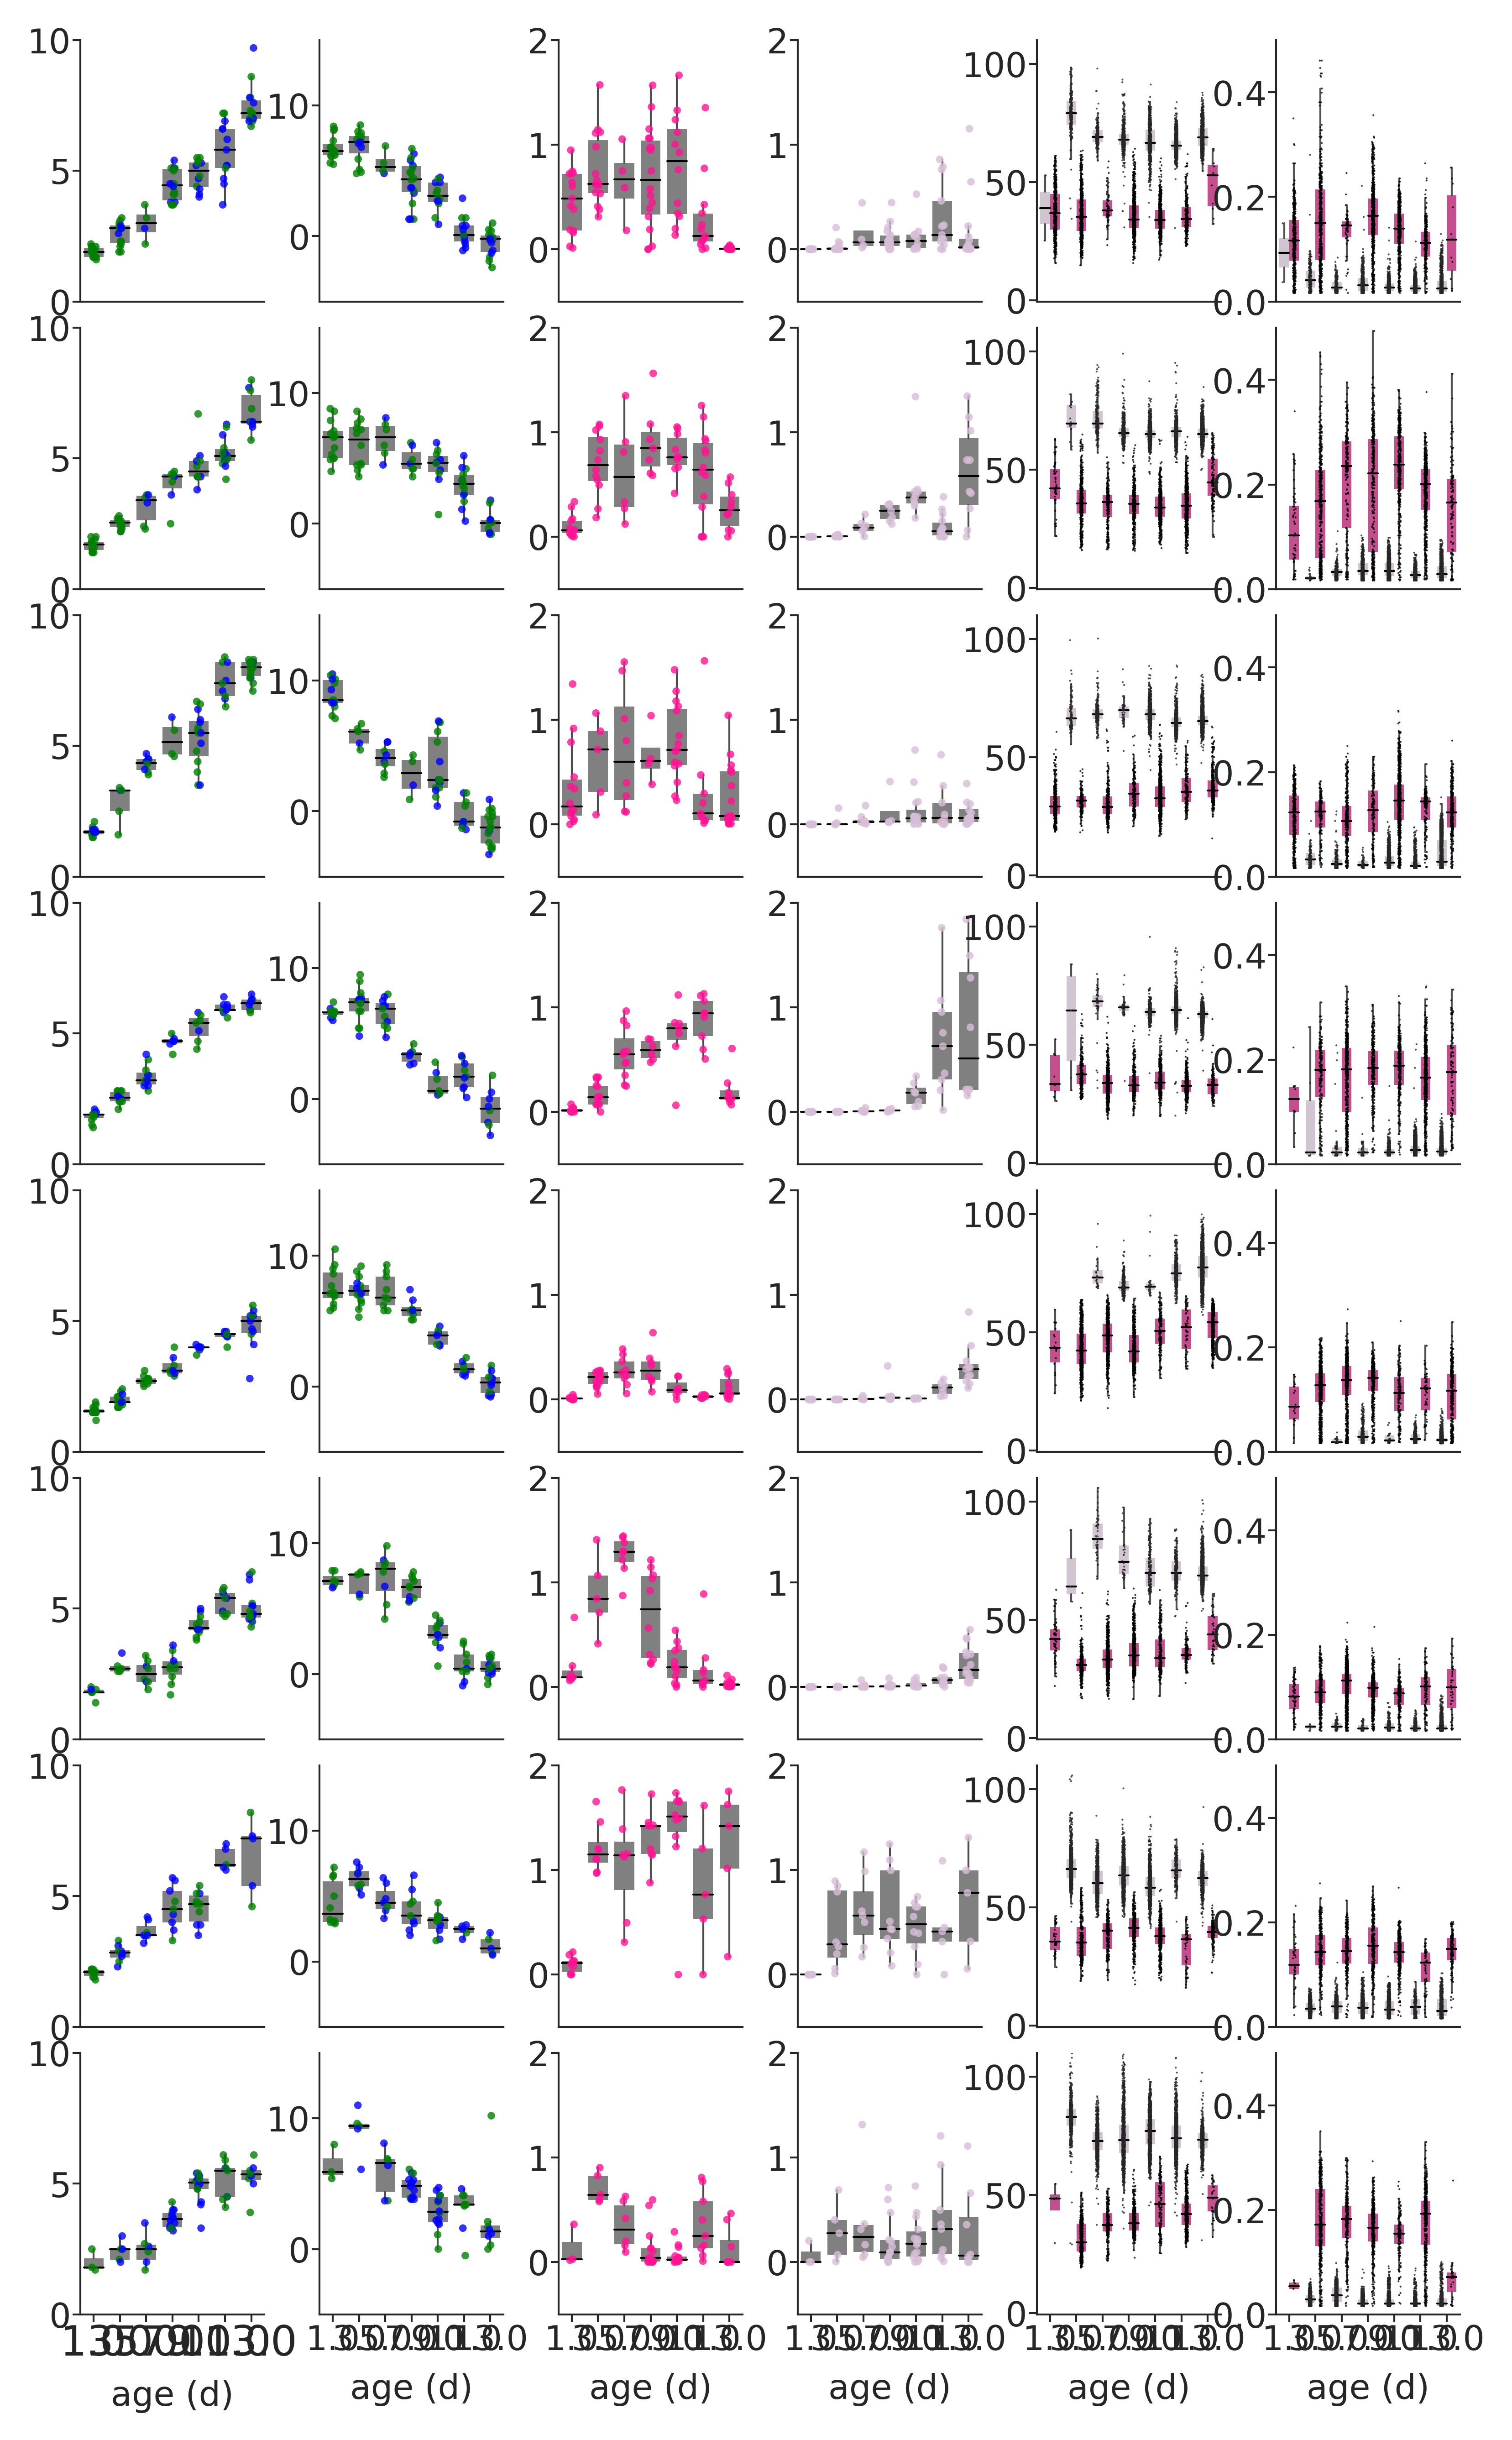

In [33]:
#plot

save = False


dot_size = 2
dot_alpha = .8
by_voc_dot_size = .5
by_voc_dot_alpha = .8
num_columns = 6
fontsize = 9
ytick_length = 2
ytick_pad = 0.5
fig, axs = plt.subplots(nrows = len(species_df), 
                        ncols = num_columns, 
                        sharex = True, 
                        figsize = (6.5, 11), 
                        dpi = 600)

plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Arial'

axs = np.array(np.concatenate(axs).flat)

counter = 0

for s, voc, c in zip(species_df,species_voc_df, colors):
    
    g1 = sns.stripplot(data = s, 
                       y = 'weight_g', 
                       x = 'age', 
                       hue = 'sex',
                       palette = {'m':'green', 'f':'blue'}, 
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 6)])
    
    g1 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 6)], 
                data=s,
                x='age', 
                y='weight_g', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    axs[num_columns*counter + (num_columns - 6)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -6)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -6)].get_yticklabels() + axs[num_columns*counter + (num_columns -5)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -6)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -6)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    #axs[num_columns*counter + (num_columns - 5)].set_ylim([-0.5, 2])
    
    axs[num_columns*counter + (num_columns - 6)].set_ylim([0, 10])
    
    g1.set(ylabel = None)
    
    if c != 'forestgreen':
        g1.set(xticklabels = [])  
        g1.set(xlabel = None)
        g1.tick_params(bottom = False) 
    else:
        #g1.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -6)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -6)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        
    ###
    g2 = sns.stripplot(data = s, 
                       y = 'temp_change', 
                       x = 'age', 
                       hue = 'sex',
                       palette = {'m':'green', 'f':'blue'}, 
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 5)])
    
    g2 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 5)], 
                data=s,
                x='age', 
                y='temp_change', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    axs[num_columns*counter + (num_columns - 5)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -5)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -5)].get_yticklabels() + axs[num_columns*counter + (num_columns -5)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -5)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -5)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    #axs[num_columns*counter + (num_columns - 5)].set_ylim([-0.5, 2])
    
    axs[num_columns*counter + (num_columns - 5)].set_ylim([-5, 15])
    
    g2.set(ylabel = None)
    
    if c != 'forestgreen':
        g2.set(xticklabels = [])  
        g2.set(xlabel = None)
        g2.tick_params(bottom = False) 
    else:
        #g1.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -5)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -5)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    
    
    ####
    g3 = sns.stripplot(data = s, 
                       y = 'cry_per_sec', 
                       x = 'age', 
                       color = 'deeppink', 
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 4)])
    
    g3 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 4)], 
                data=s,
                x='age', 
                y='cry_per_sec', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -4)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -4)].get_yticklabels() + axs[num_columns*counter + (num_columns -4)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -4)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -4)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    axs[num_columns*counter + (num_columns - 4)].set_ylim([-0.5, 2])
    axs[num_columns*counter + (num_columns - 4)].set_ylim([-0.5, 2])
    
    g3.set(ylabel = None)
    
    if c != 'forestgreen':
        g3.set(xticklabels = [])  
        g3.set(xlabel = None)
        g3.tick_params(bottom = False) 
    else:
        #g3.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -4)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -4)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    
    
    g4 = sns.stripplot(data = s, 
                       y = 'USV_per_sec', 
                       x = 'age', 
                       color = 'thistle',
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 3)])
    
    g4 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 3)], 
                data=s,
                x='age', 
                y='USV_per_sec', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -3)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -3)].get_yticklabels() + axs[num_columns*counter + (num_columns -3)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -3)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -3)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    axs[num_columns*counter + (num_columns - 3)].set_ylim([-0.5, 2])
    
    g4.set(ylabel = None)
    
    if c != 'forestgreen':
        g4.set(xticklabels = [])  
        g4.set(xlabel = None)
        g4.tick_params(bottom = False) 
    else:
        #g4.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -3)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -3)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    
    g5 = sns.stripplot(data = voc, 
                       y = 'meanfreq', 
                       x = 'age', 
                       hue = 'human_label',
                       color = 'black',
                       dodge = True,
                       s = by_voc_dot_size,
                       alpha = by_voc_dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns -2)])
    
    
#     g5 = sns.violinplot(ax=axs[num_columns*counter + (num_columns - 2)], 
#                 data=voc,
#                 y='meanfreq',
#                 x='age', 
#                 hue = 'human_label',  
#                 palette = {'cry':'deeppink', 'USV':'thistle'},
#                 dodge=True, 
#                 linewidth=0, 
#                 saturation=.5,
#                 inner=None)
    
    g5 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 2)], 
                data=voc,
                y='meanfreq',
                x='age', 
                hue = 'human_label',   
                palette = {'cry':'deeppink', 'USV':'thistle'},
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
#     g5 = sns.regplot(ax = axs[num_columns*counter + (num_columns -1)], 
#             data=s[s['proportion_cries'] != 'nan'], 
#             x = 'age', 
#             y='proportion_cries', 
#             color = 'deeppink', 
#             order=2, 
#             scatter_kws = {"s": dot_size, "alpha": dot_alpha},  
#             line_kws={"linewidth":1})
    
    #axs[num_columns*counter + (num_columns -2)].set_ylim([-0.1, 1.1])
    axs[num_columns*counter + (num_columns - 2)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -2)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -2)].get_yticklabels() + axs[num_columns*counter + (num_columns -2)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -2)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -2)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns - 2)].set_ylim([-0.5, 110])
    
    g5.set(ylabel = None)
    
    if c != 'forestgreen':
        g5.set(xticklabels = [])  
        g5.set(xlabel = None)
        g5.tick_params(bottom = False) 
    else:
        #g5.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -2)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -2)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        
    
    g6 = sns.stripplot(data = voc, 
                       y = 'duration', 
                       x = 'age', 
                       hue = 'human_label',
                       color = 'black',
                       dodge = True,
                       s = by_voc_dot_size,
                       alpha = by_voc_dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13],
                       ax = axs[num_columns*counter + (num_columns -1)])
    
    
    g6 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 1)], 
            data=voc,
            y='duration',
            x='age', 
            hue = 'human_label',   
            palette = {'cry':'deeppink', 'USV':'thistle'},
            dodge=True, 
            linewidth=.5, 
            saturation=.5,
            whis=1.5, 
            showfliers = False, 
            flierprops={"marker": ""},
            medianprops={"color": "black"},
            boxprops={"linewidth": .00001}, 
            width = .75, 
            showcaps=False)
    
#     g6 = sns.violinplot(ax=axs[num_columns*counter + (num_columns - 1)], 
#                 data=voc,
#                 y='meanfreq',
#                 x='age', 
#                 hue = 'human_label',  
#                 palette = {'cry':'deeppink', 'USV':'thistle'},
#                 dodge=True, 
#                 linewidth=0, 
#                 saturation=.5,
#                 inner=None)
    
    
#     g6 = sns.regplot(ax = axs[num_columns*counter + (num_columns -1)], 
#             data=s, 
#             scatter = False,
#             x = 'age', 
#             y='proportion_USVs', 
#             color = 'thistle', 
#             order=2,  
#             line_kws={"linewidth":1}, 
#             truncate = True)
    
    axs[num_columns*counter + (num_columns - 1)].set_ylim([0, 0.5])
    axs[num_columns*counter + (num_columns - 1)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -1)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -1)].get_yticklabels() + axs[num_columns*counter + (num_columns -1)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -1)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -1)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    
    
    g6.set(ylabel = None)
    
    if c != 'forestgreen':
        g6.set(xticklabels = [])  
        g6.set(xlabel = None)
        g6.tick_params(bottom = False) 
    else:
        axs[num_columns*counter + (num_columns -1)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -1)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        #g6.set(xlabel = 'age (days)')
    
    counter += 1
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
sns.despine()

save_dir = ''
if save:
    save_name = 'supplement_fig4_feature_panels.svg'
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    

In [113]:
#plot

save = False

dot_size = 2
dot_alpha = .5
by_voc_dot_size = .5
by_voc_dot_alpha = .5
num_columns = 6
fontsize = 9
ytick_length = 2
ytick_pad = 0.5
fig, axs = plt.subplots(nrows = len(species_df), 
                        ncols = num_columns, 
                        sharex = True, 
                        figsize = (6.5, 11), 
                        dpi = 600)

plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Arial'

axs = np.array(np.concatenate(axs).flat)

counter = 0

for s, voc, c in zip(species_df,species_voc_df, colors):
    
    g1 = sns.stripplot(data = s, 
                       y = 'weight_g', 
                       x = 'age', 
                       hue = 'sex',
                       palette = {'m':'green', 'f':'blue'}, 
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 6)])
    
    g1 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 6)], 
                data=s,
                x='age', 
                y='weight_g', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    axs[num_columns*counter + (num_columns - 6)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -6)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -6)].get_yticklabels() + axs[num_columns*counter + (num_columns -5)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -6)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -6)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    #axs[num_columns*counter + (num_columns - 5)].set_ylim([-0.5, 2])
    
    axs[num_columns*counter + (num_columns - 6)].set_ylim([0, 10])
    
    g1.set(ylabel = None)
    
    if c != 'forestgreen':
        g1.set(xticklabels = [])  
        g1.set(xlabel = None)
        g1.tick_params(bottom = False) 
    else:
        #g1.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -6)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -6)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        
    ###
    g2 = sns.stripplot(data = s, 
                       y = 'temp_change', 
                       x = 'age', 
                       hue = 'sex',
                       palette = {'m':'green', 'f':'blue'}, 
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 5)])
    
    g2 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 5)], 
                data=s,
                x='age', 
                y='temp_change', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    axs[num_columns*counter + (num_columns - 5)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -5)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -5)].get_yticklabels() + axs[num_columns*counter + (num_columns -5)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -5)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -5)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    #axs[num_columns*counter + (num_columns - 5)].set_ylim([-0.5, 2])
    
    axs[num_columns*counter + (num_columns - 5)].set_ylim([-5, 15])
    
    g2.set(ylabel = None)
    
    if c != 'forestgreen':
        g2.set(xticklabels = [])  
        g2.set(xlabel = None)
        g2.tick_params(bottom = False) 
    else:
        #g1.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -5)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -5)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    
    
    ####
    g3 = sns.stripplot(data = s, 
                       y = 'cry_per_sec', 
                       x = 'age', 
                       color = 'deeppink', 
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 4)])
    
    g3 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 4)], 
                data=s,
                x='age', 
                y='cry_per_sec', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -4)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -4)].get_yticklabels() + axs[num_columns*counter + (num_columns -4)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -4)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -4)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    axs[num_columns*counter + (num_columns - 4)].set_ylim([-0.5, 2])
    axs[num_columns*counter + (num_columns - 4)].set_ylim([-0.5, 2])
    
    g3.set(ylabel = None)
    
    if c != 'forestgreen':
        g3.set(xticklabels = [])  
        g3.set(xlabel = None)
        g3.tick_params(bottom = False) 
    else:
        #g3.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -4)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -4)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    
    
    g4 = sns.stripplot(data = s, 
                       y = 'USV_per_sec', 
                       x = 'age', 
                       color = 'thistle',
                       s = dot_size,
                       alpha = dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns - 3)])
    
    g4 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 3)], 
                data=s,
                x='age', 
                y='USV_per_sec', 
                color = 'grey',
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -3)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -3)].get_yticklabels() + axs[num_columns*counter + (num_columns -3)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -3)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -3)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    axs[num_columns*counter + (num_columns - 3)].set_ylim([-0.5, 2])
    
    g4.set(ylabel = None)
    
    if c != 'forestgreen':
        g4.set(xticklabels = [])  
        g4.set(xlabel = None)
        g4.tick_params(bottom = False) 
    else:
        #g4.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -3)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -3)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    
    g5 = sns.stripplot(data = voc, 
                       y = 'meanfreq', 
                       x = 'age', 
                       hue = 'human_label',
                       color = 'black',
                       dodge = True,
                       s = by_voc_dot_size,
                       alpha = by_voc_dot_alpha,
                       order = [1, 3, 5, 7, 9, 11, 13], 
                       ax = axs[num_columns*counter + (num_columns -2)])
    
    
#     g5 = sns.violinplot(ax=axs[num_columns*counter + (num_columns - 2)], 
#                 data=voc,
#                 y='meanfreq',
#                 x='age', 
#                 hue = 'human_label',  
#                 palette = {'cry':'deeppink', 'USV':'thistle'},
#                 dodge=True, 
#                 linewidth=0, 
#                 saturation=.5,
#                 inner=None)
    
    g5 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 2)], 
                data=voc,
                y='meanfreq',
                x='age', 
                hue = 'human_label',   
                palette = {'cry':'deeppink', 'USV':'thistle'},
                dodge=True, 
                linewidth=.5, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)
    
#     g5 = sns.regplot(ax = axs[num_columns*counter + (num_columns -1)], 
#             data=s[s['proportion_cries'] != 'nan'], 
#             x = 'age', 
#             y='proportion_cries', 
#             color = 'deeppink', 
#             order=2, 
#             scatter_kws = {"s": dot_size, "alpha": dot_alpha},  
#             line_kws={"linewidth":1})
    
    #axs[num_columns*counter + (num_columns -2)].set_ylim([-0.1, 1.1])
    axs[num_columns*counter + (num_columns - 2)].legend([],[], frameon = False)
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -2)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -2)].get_yticklabels() + axs[num_columns*counter + (num_columns -2)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -2)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -2)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns - 2)].set_ylim([-0.5, 110])
    
    g5.set(ylabel = None)
    
    if c != 'forestgreen':
        g5.set(xticklabels = [])  
        g5.set(xlabel = None)
        g5.tick_params(bottom = False) 
    else:
        #g5.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -2)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -2)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        
  #######  
#     g6 = sns.stripplot(data = s[s['proportion_cries'] != 'nan'], 
#                        y = 'proportion_cries', 
#                        x = 'age', 
#                        color = 'deeppink',
#                        s = dot_size,
#                        alpha = dot_alpha, 
#                        **{'linewidths': 0},
#                        jitter=False,
#                        order = [1, 3, 5, 7, 9, 11, 13], 
#                     ax = axs[num_columns*counter + (num_columns -1)])
    
#     g5 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 1)], 
#                 data=s,
#                 x='age', 
#                 y='proportion_cries', 
#                 color = 'grey',
#                 dodge=True, 
#                 linewidth=.5, 
#                 saturation=.5,
#                 whis=1.5, 
#                 showfliers = False, 
#                 flierprops={"marker": ""},
#                 medianprops={"color": "black"},
#                 boxprops={"linewidth": .00001}, 
#                 width = .75, 
#                 showcaps=False)
    
    g6 = sns.regplot(ax = axs[num_columns*counter + (num_columns -1)], 
            data=s, 
            scatter = True,
            x = 'age', 
            y='proportion_cries', 
            color = 'deeppink', 
            order=2, 
            scatter_kws = {"s": dot_size, "alpha": dot_alpha},  
            line_kws={"linewidth":1}, 
            truncate = True)
    
    axs[num_columns*counter + (num_columns -2)].set_ylim([-0.1, 1.1])
  
    
    g6.set(ylabel = None)
    
    if c != 'forestgreen':
        g6.set(xticklabels = [])  
        g6.set(xlabel = None)
        g6.tick_params(bottom = False) 
    else:
        #g5.set(xlabel = 'age (days)')
        axs[num_columns*counter + (num_columns -1)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -1)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)

    axs[num_columns*counter + (num_columns -1)].set_ylim([-0.1, 1.1])
    
    for axis in ['top','bottom','left','right']:
        axs[num_columns*counter + (num_columns -1)].spines[axis].set_linewidth(.5)
        
    for label in (axs[num_columns*counter + (num_columns -1)].get_yticklabels() + axs[num_columns*counter + (num_columns -1)].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axs[num_columns*counter + (num_columns -1)].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axs[num_columns*counter + (num_columns -1)].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
        
#     g7 = sns.stripplot(data = s[s['proportion_USVs'] != 'nan'], 
#                        y = 'proportion_USVs', 
#                        x = 'age', 
#                        color = 'thistle',
#                        s = dot_size,
#                        alpha = dot_alpha,
#                        **{'linewidths': 0},
#                        jitter=False,
#                        order = [1, 3, 5, 7, 9, 11, 13], 
#                        ax = axs[num_columns*counter + (num_columns -1)])
    
#     g6 = sns.boxplot(ax=axs[num_columns*counter + (num_columns - 1)], 
#                 data=s,
#                 x='age', 
#                 y='proportion_USVs', 
#                 color = 'grey',
#                 dodge=True, 
#                 linewidth=.5, 
#                 saturation=.5,
#                 whis=1.5, 
#                 showfliers = False, 
#                 flierprops={"marker": ""},
#                 medianprops={"color": "black"},
#                 boxprops={"linewidth": .00001}, 
#                 width = .75, 
#                 showcaps=False)
    
    
    g7 = sns.regplot(ax = axs[num_columns*counter + (num_columns -1)], 
            data=s, 
            scatter = True,
            x = 'age', 
            y='proportion_USVs', 
            color = 'thistle', 
            order=2,  
            line_kws={"linewidth":1},
            scatter_kws = {"s": dot_size, "alpha": dot_alpha},
            truncate = True)
 
    g7.set(ylabel = None)
    
    if c != 'forestgreen':
        g7.set(xticklabels = [])  
        g7.set(xlabel = None)
        g7.tick_params(bottom = False) 
    else:
        axs[num_columns*counter + (num_columns -1)].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
        axs[num_columns*counter + (num_columns -1)].set_xticks([1,3,5,7,9,11,13])
        axs[num_columns*counter + (num_columns -1)].set_xticklabels([1,3,5,7,9,11,13])
#####
    counter += 1
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
sns.despine()

save_dir = ''
if save:
    save_name = 'supplement_fig4_proportions_panel.svg'
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    

# Supplemental Figure 5 (inter-onset intervals)

## get the data

In [114]:
#paths to the data
save_dir = ''
vocs_save_name = 'figure2_all_development_vocs_with_predictions.csv'

#the vocalizations
development_vocs_df = pd.read_csv(os.path.join(save_dir, vocs_save_name))

#drop the features - you don't need them
development_vocs_df = development_vocs_df.drop(columns = [i for i in params_dict['supp_figure_3']['features'] if i!='duration'])

#their start and stop times
development_vocs_times_df_path = ''
development_vocs_times_df = pd.read_csv(development_vocs_times_df_path)

#clean up before merging
development_vocs_times_df = development_vocs_times_df.loc[development_vocs_times_df['species'].isin(development_vocs_df['species'].unique())]
development_vocs_times_df = development_vocs_times_df.rename(columns={'source_file': 'full_wav_file'})



In [115]:
#get voc numbers needed for merging
from tqdm import tqdm
voc_numbers = []
for i in tqdm(development_vocs_times_df['full_wav_file'].unique()):
    num_vocs = len(development_vocs_times_df.loc[development_vocs_times_df['full_wav_file'] == i])
    voc_numbers.extend(list(range(num_vocs)))
development_vocs_times_df['clip_number'] = voc_numbers

#mrecreate clip .wav names for merging
development_vocs_times_df['source_file'] = [i.split('.')[0] + '_clip_' + str(j) + '.wav' for i,j in zip(development_vocs_times_df['full_wav_file'], development_vocs_times_df['clip_number'])]

print('done.')

In [5]:
#merge
merged_df = development_vocs_times_df.merge(development_vocs_df, on = 'source_file')
merged_df['duration_x'] = [np.round(i,3) for i in merged_df['duration_x']]
merged_df['duration_y'] = [np.round(i,3) for i in merged_df['duration_y']]
assert merged_df['duration_x'].equals(merged_df['duration_y'])
assert merged_df['species_x'].equals(merged_df['species_y'])
merged_df = merged_df.drop(columns = ['duration_x', 'species_x'])
merged_df = merged_df.rename(columns = {'duration_y':'duration', 'species_y':'species'})

#check there are no duplicates
assert merged_df.duplicated(subset = 'source_file').sum() == 0

#drop scratches and Mus
merged_df = merged_df.loc[merged_df['predicted_label'].isin(['cry', 'USV'])]
merged_df = merged_df.loc[~merged_df['species'].isin(['MU', 'MZ'])]


In [116]:
# get interonset intervals by vocalization type TODO: put this in a function

# CALCULATE IOIs
# use the start and stop times from the data frame you just generated to calculate interonset intervals for 
# cries and USVs at a given age
from tqdm import tqdm
merged_df['age'] = [int(i.split('_')[10][1:]) for i in merged_df['source_file']]
pups = merged_df['full_wav_file'].unique()
voc_types = merged_df['predicted_label'].unique()
print(len(pups))
cry_or_USV = []
IOIs = []
ages = []
full_wav_files = []
source_files = []
pups_done = 0
pups_total = len(merged_df)

for voc_type in voc_types:
    print(voc_type)
    
    for pup in tqdm(pups):
            
        tdf = merged_df.loc[merged_df['predicted_label'] == voc_type].loc[merged_df['full_wav_file'] == pup].sort_values(by = 'start_seconds')
        
        #get the interonset interval 
        IOIs.extend(tdf['start_seconds'].diff()) 
 
        #get the other info you need to add this back to the main phenotypes file
        ages.extend(list(merged_df['age'].loc[merged_df['predicted_label'] == voc_type].loc[merged_df['full_wav_file'] == pup]))
        full_wav_files.extend(list(merged_df['full_wav_file'].loc[merged_df['predicted_label'] == voc_type].loc[merged_df['full_wav_file'] == pup]))
        cry_or_USV.extend(list(merged_df['predicted_label'].loc[merged_df['predicted_label'] == voc_type].loc[merged_df['full_wav_file'] == pup]))
        source_files.extend(list(merged_df['source_file'].loc[merged_df['predicted_label'] == voc_type].loc[merged_df['full_wav_file'] == pup]))
        pups_done+=1

            

In [7]:
#make a df for the interonset intervals
ioi_df = pd.DataFrame()
ioi_df['ioi'] = IOIs
ioi_df['age'] = ages
ioi_df['full_wav_file'] = full_wav_files
ioi_df['species'] = [i.split('_')[0] for i in ioi_df['full_wav_file']]
ioi_df['source_file'] = source_files
ioi_df['clip_number'] = [i.split('_clip_')[-1].split('.')[0] for i in ioi_df['source_file']]
ioi_df['voc_type'] = cry_or_USV
ioi_df['log_ioi'] = np.log2(ioi_df['ioi'])
ioi_df = ioi_df.dropna()

In [117]:
#plot ioi distributions by pup in grey and pooled in black
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib as mpl


save = False

fontsize=9
avg_width = 2
avg_alpha = .9
individual_alpha = 0.25
individual_width = .5
fontsize =6
ytick_length = 2
ytick_pad = 0.5

fig, axes = plt.subplots(nrows =8, 
                         ncols =2, 
                         constrained_layout=True, 
                         figsize = [3,9], 
                         dpi=600, 
                         sharex=True, 
                         sharey=True)

viridis_big = cm.get_cmap('viridis', 8)
newcmp = ListedColormap(viridis_big(np.linspace(0, 1, 8)))
age_color_dict = {1: newcmp(0.01), 
                  3: newcmp(0.18), 
                  5: newcmp(0.35),
                  7: newcmp(0.5),
                  9: newcmp(0.68),
                  11: newcmp(0.85),
                  13: newcmp(0.98)}

import seaborn as sns
color_dict = {1:'blue', 3:'green'}
all_cry_iois = []
all_USV_iois = []
species_list = ['BW', 'SW', 'NB', 'BK', 'PO', 'LO', 'GO', 'LL']

for species, ax in zip(species_list, range(8)):
    
    #plot cries
    cry_species_ioi_df = ioi_df.loc[ioi_df['species'] == species].loc[ioi_df['voc_type'] == 'cry']
    USV_species_ioi_df = ioi_df.loc[ioi_df['species'] == species].loc[ioi_df['voc_type'] == 'USV']

    df = cry_species_ioi_df

    #for each pup
    for pup in df['full_wav_file'].unique():
        if len(df.loc[df['full_wav_file'] == pup]) > 10:
            temp = df.loc[df['full_wav_file'] == pup]
            sns.kdeplot(temp['ioi'], 
                        alpha=individual_alpha, 
                        linewidth=individual_width, 
                        color = age_color_dict[temp['age'].unique()[0]], 
                        ax=axes[ax, 0], log_scale=True)
    
    #pooled
    sns.kdeplot(df['ioi'], 
                color='black',
                linewidth =avg_width, 
                alpha = avg_alpha,  
                ax=axes[ax, 0], 
                log_scale=True, 
                legend=False)
    
#     #pooled by age
#     sns.kdeplot(df['ioi'], 
#                 hue = df['age'],
#                 palette = age_color_dict,
#                 linewidth =1, 
#                 alpha = avg_alpha,  
#                 ax=axes[ax, 0], 
#                 log_scale=True, 
#                 legend=False)
    
    for axis in ['top','bottom','left','right']:
        axes[ax,0].spines[axis].set_linewidth(.5)
        
    for label in (axes[ax,0].get_yticklabels() + axes[ax,0].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axes[ax,0].set_xlim([10e-3,10e2])
    axes[ax,0].set_ylabel('')
    axes[ax,0].set_xlabel('interonset interval (s)', fontsize=fontsize)
    axes[ax,0].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[ax,0].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

    
    #plot USVs
    df = USV_species_ioi_df

    #for each pup
    for pup in df['full_wav_file'].unique():
        if len(df.loc[df['full_wav_file'] == pup]) > 10:
            temp = df.loc[df['full_wav_file'] == pup]
            sns.kdeplot(temp['ioi'], 
                        alpha = individual_alpha, 
                        linewidth=individual_width, 
                        color = age_color_dict[temp['age'].unique()[0]], 
                        ax=axes[ax, 1], 
                        log_scale=True)

    
    #pooled
    sns.kdeplot(df['ioi'], 
                color='black',
                linewidth =avg_width, 
                alpha = avg_alpha,  
                ax=axes[ax, 1], 
                log_scale=True, 
                legend=False)
    
#     #pooled by age
#     sns.kdeplot(df['ioi'], 
#                 hue = df['age'],
#                 palette = age_color_dict,
#                 linewidth =1, 
#                 alpha = avg_alpha,  
#                 ax=axes[ax, 1], 
#                 log_scale=True, 
#                 legend=False)
    
    for axis in ['top','bottom','left','right']:
        axes[ax,1].spines[axis].set_linewidth(.5)
        
    for label in (axes[ax,1].get_yticklabels() + axes[ax,1].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    axes[ax,1].set_xlim([10e-3,10e2])
    axes[ax,1].set_ylabel('')
    axes[ax,1].set_xlabel('interonset interval (s)', fontsize=fontsize)
    axes[ax,1].yaxis.set_tick_params(width=.1, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[ax,1].xaxis.set_tick_params(width=.1, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    sns.despine()
    
save_dir = ''
if save:
    save_name = 'ioi_plots.svg'
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    


In [118]:
#plot all the pups


save = False
fontsize =6
ytick_length = 2
ytick_pad = 0.5


fig, axes = plt.subplots(nrows =8, 
                         ncols =4, 
                         constrained_layout=True, 
                         figsize = [4,8], 
                         dpi=600)


species_list = ['BW', 'SW', 'NB', 'BK', 'PO', 'LO', 'GO', 'LL']

for row, species in enumerate(species_list):
    print(species)

    #these are hand picked examples - I looked at max three pups from each age and picked ones that had 
    # a similar number of cries and USVs, each >~20
    if species == 'BK':
        age = 11
        pup_num = 15

    if species == 'BW':
        age = 9
        pup_num = 2

    if species == 'NB':
        age = 9
        pup_num = 0

    if species == 'SW':
        age = 9
        pup_num = 6

    if species == 'PO':
        age = 13
        pup_num = 2

    if species == 'LO':
        age = 11
        pup_num = 0

    if species == 'GO':
        age = 9
        pup_num = 1

    if species == 'LL':
        age = 11
        pup_num = 1
        
    pup = ioi_df['full_wav_file'].loc[ioi_df['species'] == species].loc[ioi_df['age'] == age].unique()[pup_num]
    pup_name = pup.split('.')[0]
    ISI_name = 'ioi'
    cdf = ioi_df.loc[ioi_df['voc_type'] == 'cry'].loc[ioi_df['full_wav_file'] == pup][1:].sort_values(by = ISI_name)
    wdf = ioi_df.loc[ioi_df['voc_type'] == 'USV'].loc[ioi_df['full_wav_file'] == pup][1:].sort_values(by = ISI_name)

    #calculate difference between each ISI and every other ISI
    import numpy as np

    #initialize arrays
    cIOIdiffs = np.zeros([len(cdf), len(cdf)])
    wIOIdiffs = np.zeros([len(wdf), len(wdf)])

    #for each cry logISI value, subtract it from all other logISI values including itself, take the absolute value, and add 
    #all these values to the cIOIdiffs array you just made
    for crow in range(len(cIOIdiffs)):
        cIOIdiff = list(abs(cdf['log_ioi'] - cdf['log_ioi'].iloc[crow]))
        cIOIdiffs[crow] = cIOIdiff

    #do the same thing but for USVs
    for wrow in range(len(wIOIdiffs)):
        wIOIdiff = list(abs(wdf['log_ioi'] - wdf['log_ioi'].iloc[wrow]))
        wIOIdiffs[wrow] = wIOIdiff

    #Make the plots

    import seaborn as sns
    import matplotlib.pyplot as plt

    #make a mask for the USVs to hide upper (redundant) triangle of matrix
    wmask = np.zeros_like(wIOIdiffs)
    wmask[np.triu_indices_from(wmask)] = True

    #make a mask for the criesto hide upper (redundant) triangle of matrix
    cmask = np.zeros_like(cIOIdiffs)
    cmask[np.triu_indices_from(cmask)] = True

    sns.histplot(cdf['ioi'], ax=axes[row,0], binwidth = .2, linewidth = .001, log_scale=True, color = 'deeppink')
    sns.heatmap(cIOIdiffs, ax=axes[row,1], mask = cmask, cmap = 'viridis')
    sns.histplot(wdf['ioi'], ax=axes[row,2], binwidth = .2, linewidth = .001, log_scale=True, color = 'thistle')
    sns.heatmap(wIOIdiffs, ax=axes[row,3], mask = wmask, cmap = 'viridis', annot_kws={"fontsize":8}, cbar_kws = {'drawedges':False})

    for i in [0,1,2,3]:

        axes[row,i].yaxis.set_tick_params(width=.1, rotation = 0, length = ytick_length, pad = ytick_pad)
        axes[row,i].xaxis.set_tick_params(width=.1, rotation = 0, length = ytick_length, pad = ytick_pad)

        for axis in ['top','bottom','left','right']:
                axes[row,i].spines[axis].set_linewidth(.5)

        for label in (axes[row,i].get_yticklabels() + axes[row,i].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)


    axes[row,0].set_ylabel('')
    axes[row,2].set_ylabel('')
    axes[row,0].set_xlabel('')
    axes[row,2].set_xlabel('')
    axes[row,1].axes.get_xaxis().set_visible(False)
    axes[row,1].axes.get_yaxis().set_visible(False)
    axes[row,3].axes.get_xaxis().set_visible(False)
    axes[row,3].axes.get_yaxis().set_visible(False)

    cbar = axes[row,1].collections[0].colorbar
    cbar.ax.tick_params(labelsize=6, grid_linewidth=0, width=0.5)
    cbar.outline.set_linewidth(0)

    cbar = axes[row,3].collections[0].colorbar
    cbar.ax.tick_params(labelsize=6, grid_linewidth=0, width=0.5)
    cbar.outline.set_linewidth(0)

    sns.despine()
    fig.show()
    
    save_dir = ''
    if save:
        save_name = species+'_pups_example_IOIs.jpeg'
        plt.savefig(os.path.join(save_dir,save_name))



In [ ]:
#Generate a df of differences between every IOI and every other IOI
save=False

species = 'BK'
age = 11
pup_num = 15

fontsize =6
ytick_length = 2
ytick_pad = 0.5


#plot
fig, axes = plt.subplots(nrows =1, 
                         ncols =4, 
                         constrained_layout=True, 
                         figsize = [4,1], 
                         dpi=600)

pup = ioi_df['full_wav_file'].loc[ioi_df['species'] == species].loc[ioi_df['age'] == age].unique()[pup_num]
pup_name = pup.split('.')[0]
ISI_name = 'ioi'
cdf = ioi_df.loc[ioi_df['voc_type'] == 'cry'].loc[ioi_df['full_wav_file'] == pup][1:].sort_values(by = ISI_name)
wdf = ioi_df.loc[ioi_df['voc_type'] == 'USV'].loc[ioi_df['full_wav_file'] == pup][1:].sort_values(by = ISI_name)

#calculate difference between each ISI and every other ISI
import numpy as np

#initialize arrays
cIOIdiffs = np.zeros([len(cdf), len(cdf)])
wIOIdiffs = np.zeros([len(wdf), len(wdf)])
    
#for each cry logISI value, subtract it from all other logISI values including itself, take the absolute value, and add 
#all these values to the cIOIdiffs array you just made
for crow in range(len(cIOIdiffs)):
    cIOIdiff = list(abs(cdf['log_ioi'] - cdf['log_ioi'].iloc[crow]))
    cIOIdiffs[crow] = cIOIdiff

#do the same thing but for USVs
for wrow in range(len(wIOIdiffs)):
    wIOIdiff = list(abs(wdf['log_ioi'] - wdf['log_ioi'].iloc[wrow]))
    wIOIdiffs[wrow] = wIOIdiff

#Make the plots

import seaborn as sns
import matplotlib.pyplot as plt

#make a mask for the USVs to hide upper (redundant) triangle of matrix
wmask = np.zeros_like(wIOIdiffs)
wmask[np.triu_indices_from(wmask)] = True

#make a mask for the criesto hide upper (redundant) triangle of matrix
cmask = np.zeros_like(cIOIdiffs)
cmask[np.triu_indices_from(cmask)] = True

sns.histplot(cdf['ioi'], ax=axes[0], binwidth = .2, linewidth = .001, log_scale=True, color = 'deeppink')
sns.heatmap(cIOIdiffs, ax=axes[1], mask = cmask, cmap = 'viridis')
sns.histplot(wdf['ioi'], ax=axes[2], binwidth = .2, linewidth = .001, log_scale=True, color = 'thistle')
sns.heatmap(wIOIdiffs, ax=axes[3], mask = wmask, cmap = 'viridis', annot_kws={"fontsize":8}, cbar_kws = {'drawedges':False})

for i in [0,1,2,3]:
    
    axes[i].yaxis.set_tick_params(width=.1, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[i].xaxis.set_tick_params(width=.1, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    for axis in ['top','bottom','left','right']:
            axes[i].spines[axis].set_linewidth(.5)

    for label in (axes[i].get_yticklabels() + axes[i].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

          
axes[0].set_ylabel('')
axes[2].set_ylabel('')
axes[0].set_xlabel('')
axes[2].set_xlabel('')
axes[1].axes.get_xaxis().set_visible(False)
axes[1].axes.get_yaxis().set_visible(False)
axes[3].axes.get_xaxis().set_visible(False)
axes[3].axes.get_yaxis().set_visible(False)

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=6, grid_linewidth=0, width=0.5)
cbar.outline.set_linewidth(0)

cbar = axes[3].collections[0].colorbar
cbar.ax.tick_params(labelsize=6, grid_linewidth=0, width=0.5)
cbar.outline.set_linewidth(0)

sns.despine()
fig.show()

save_dir = ''
if save:
    save_name = ('_').join([pup_name,'example_IOIs.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name))
